# Project of Mobile Robotics 

*Students: Farasoa Deborah Rajaona, Yasmine El Goumi, Alexandre de Montleau, François Charroin*

# Table of contents
1. [Introduction](#intro)
    * 1.1 [Description of the setup](#setup)
    * 1.2 [Description of the tools used](#tools)


2. [Vision](#vision)
    * 2.1 [Detection of obstacles](#obs)
    * 2.2 [Detection of start and goal](#start)
    * 2.3 [Discussion](#visiondiscus)
       
        
3. [Global navigation](#globalnav)
    * 3.1 [Creation of the grid](#grid)
    * 3.2 [A*](#astar)
    * 3.3 [Discussion](#globaldis)
    
       
4. [Local Navigation](#loc)
    * 4.1 [Obstacle avoidance](#obstacleavoidance)
    * 4.2 [Discussion](#locdiscus)
    

5. [Motion control](#mov)
    * 5.1 [Theory](#motiontheory)
    * 5.2 [Implementation](#motionimplementation)
    * 5.3 [Discussion](#motiondis)


6. [Kalman Filter](#kal)
    * 6.1 [Theory](#kaltheory)
    * 6.2 [Implementation](#kalimplementation)
    * 6.3 [Discussion](#kaldiscussion)
    

7. [Overall Code Implementation](#ov)


8. [Conclusion](#con)
    * [Feedback](#feedback)
    

9. [Appendix](#appendix)
    * [Electronic devices used](#elec)
    * [Video of the implementation](#video)
    * [References](#ref)


# 1. Introduction<a name="intro"></a>

As part of our Robotics master at EPFL, we have to program a mobile robot to follow a trajectory. This project consists of 4 different steps: create an environnement, find the best path, control the movements, and avoid obstacles. They require to develop tools: vision, global navigation, local navigation, filtering and motion control.

The full code can be found in the zip folder under the name "Projet_final.ipynb".


## Description of the setup <a name="setup"></a>

A camera ([Aukey pc w1](#elec)) is placed above the robot and has a view of the entire environnement set for the project. This environnement has been meticulously chosen so that the colors are easely separated by some thresholding functions. The robot has two pieces of different colored paper (green and red) on its top so that the position and the angle can be deduced. The goal to reach is defined by a blue piece of paper. Obstacles are in black and the ground is white. 

<div>
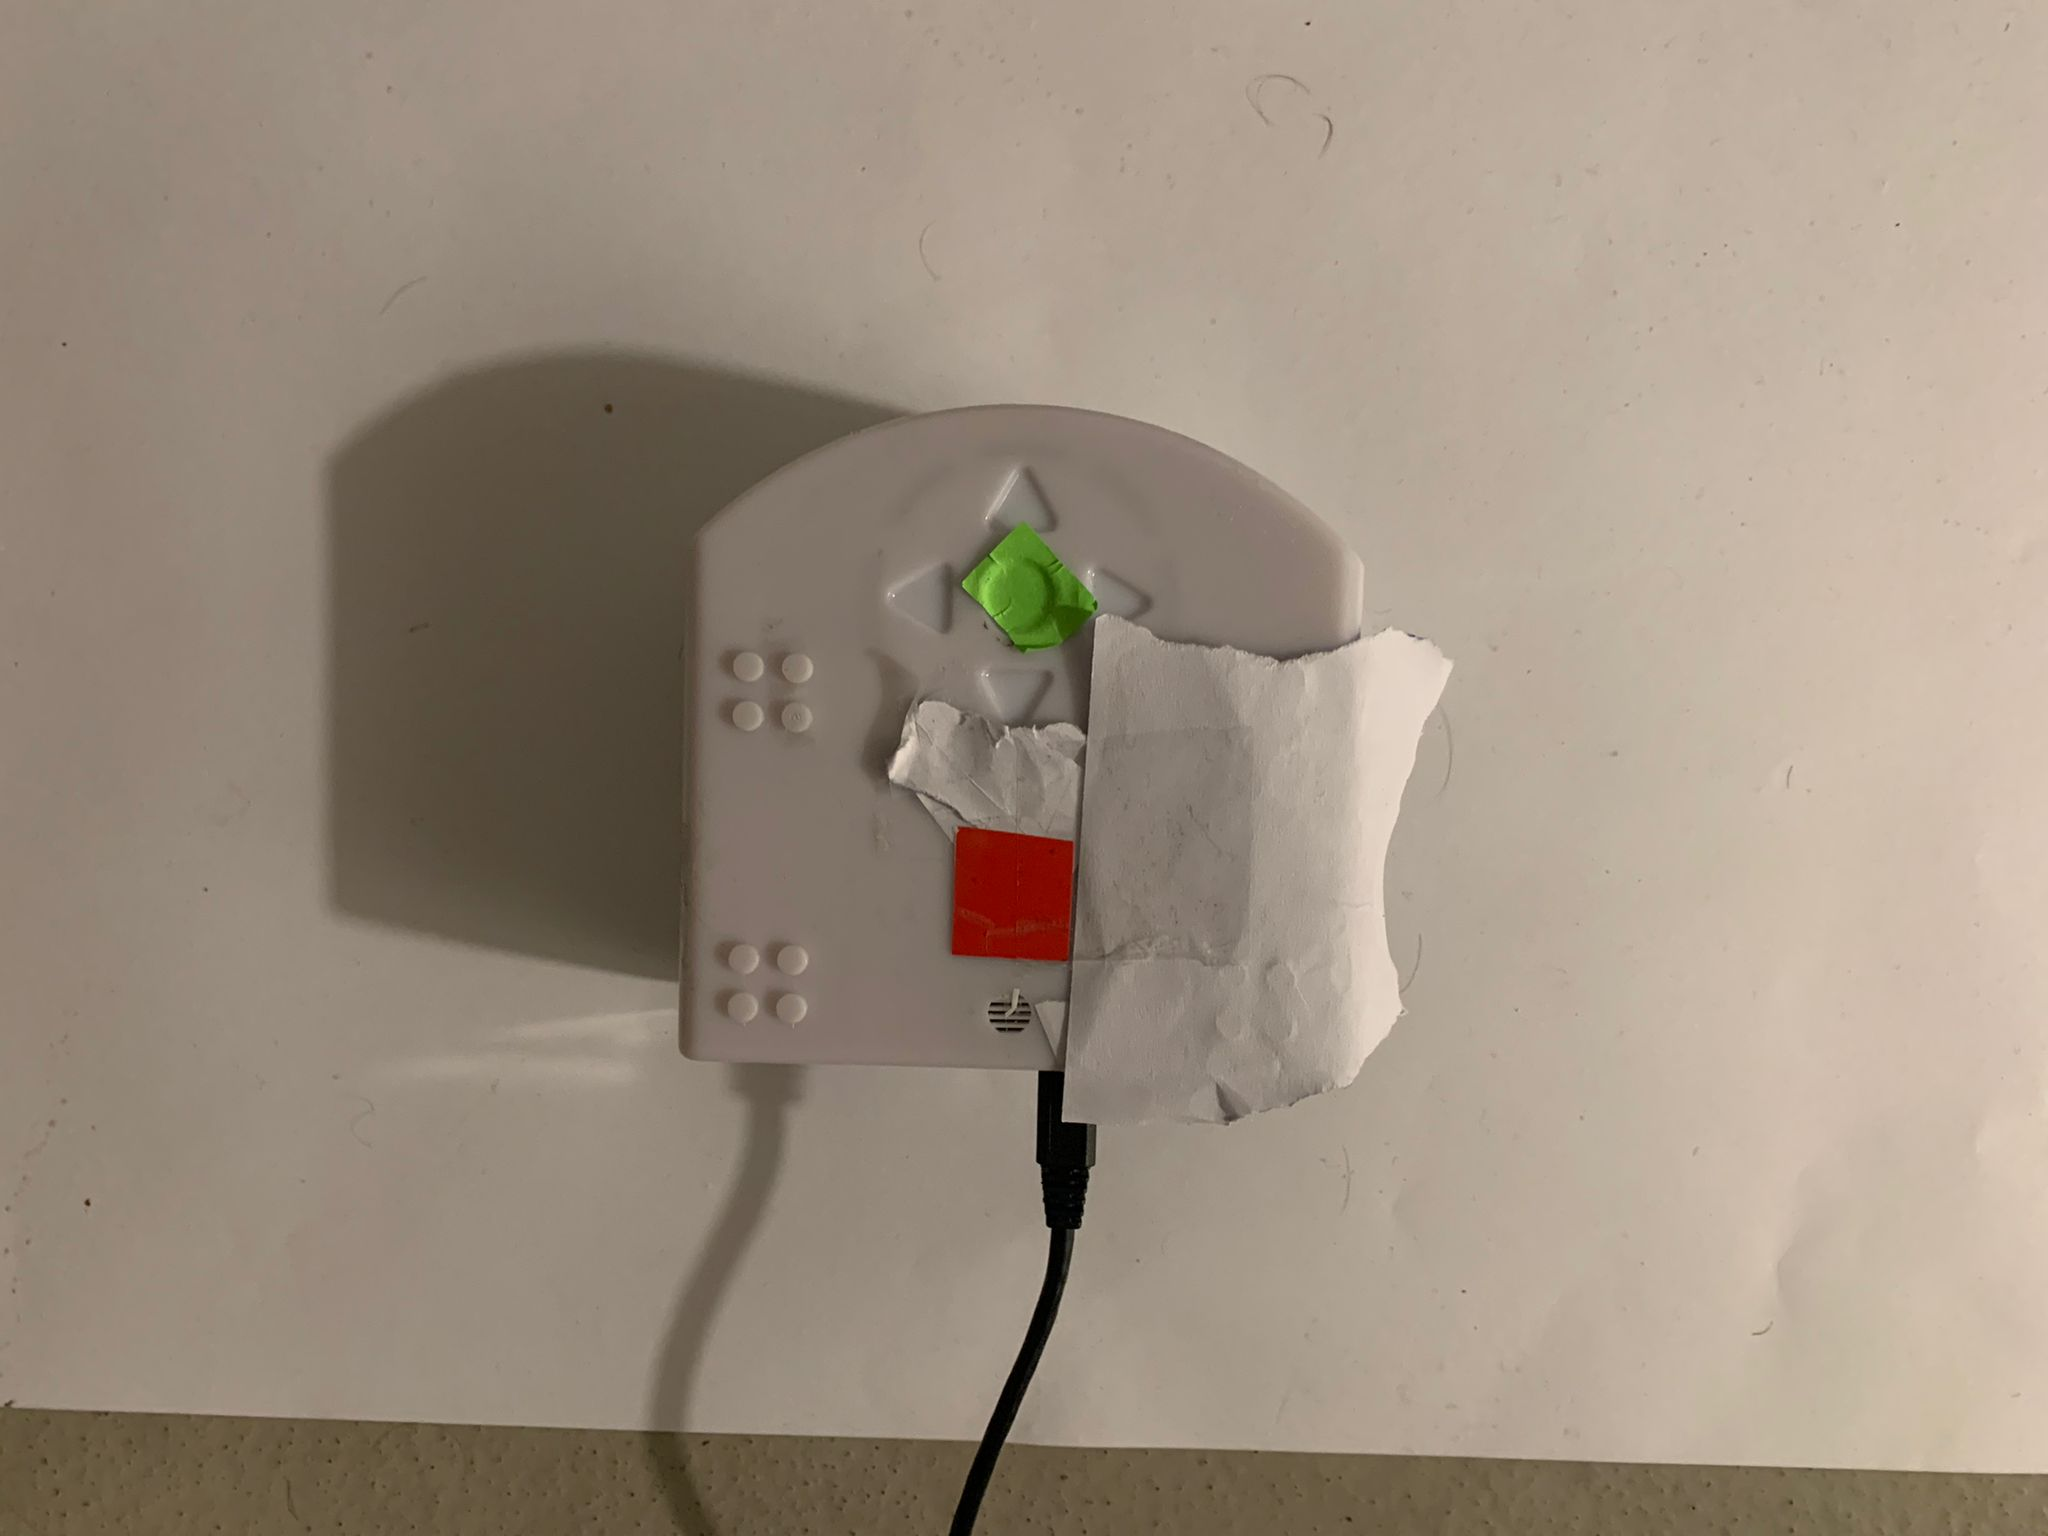
</div>

<div>
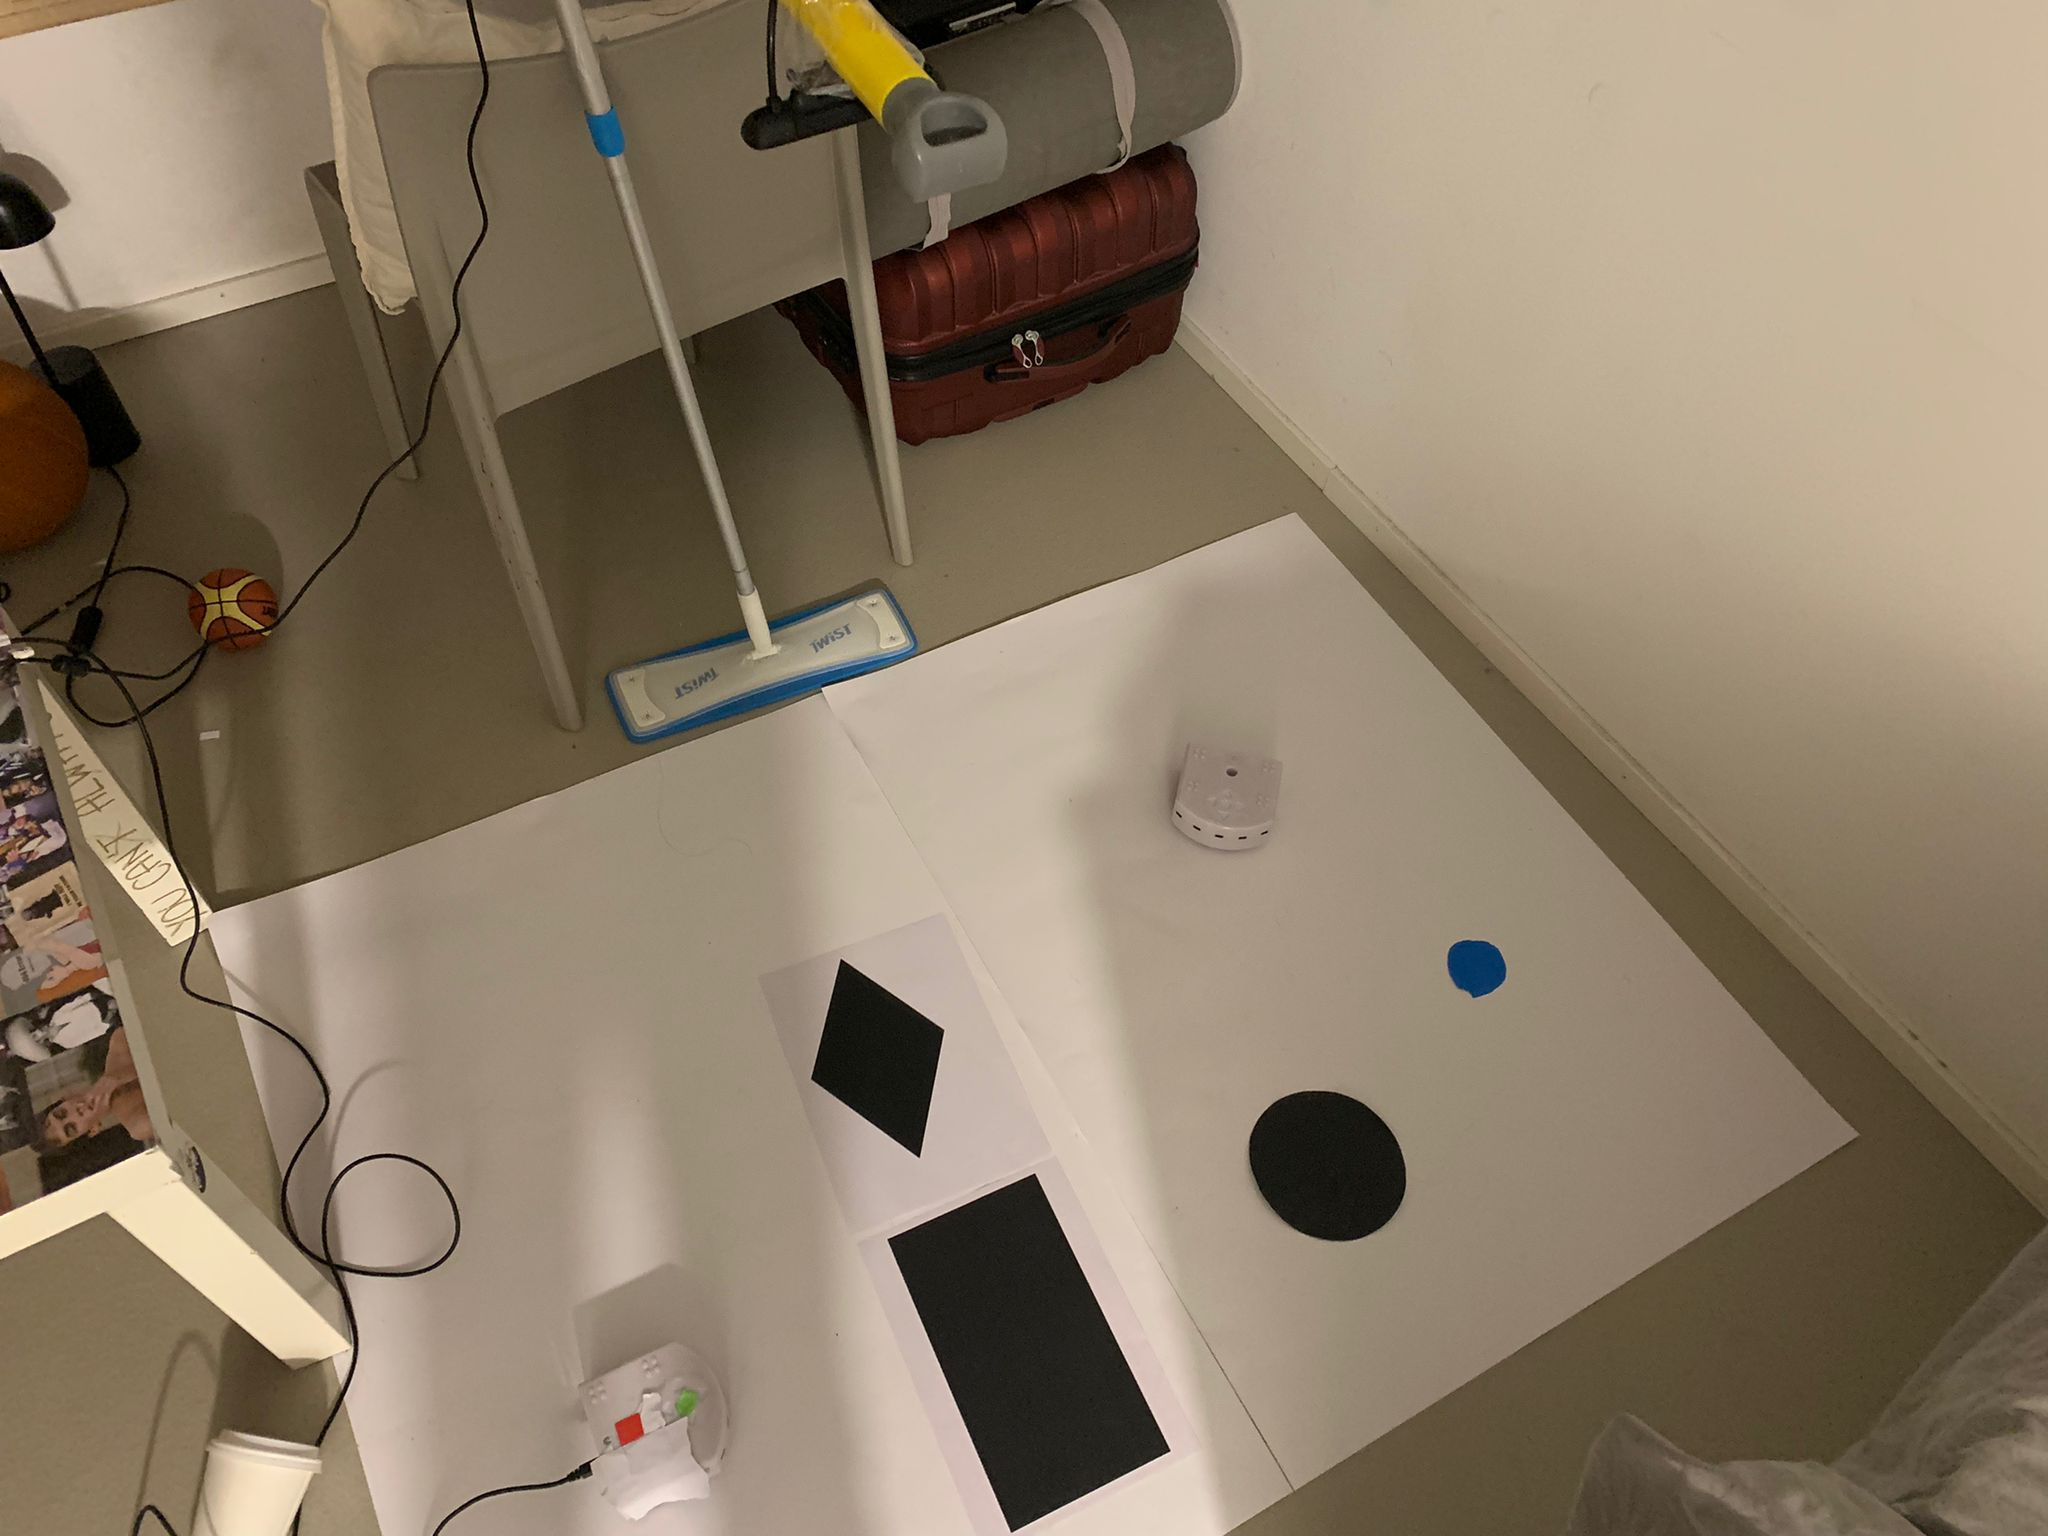
</div>

## Description of tools used <a name="tools"></a>

* __Vision:__
the camera, thresholding functions and filters from CV2 librairy are used to assess the position of the obstacles, the goal and the thymio.
* __Global navigation:__
an occupancy grid is filled by A* search algorithm to find the best path between the start and the goal.
* __Local navigation:__
the proximity sensors of the Thymio are used to detect obstacles and start an obstacle avoidance routine
* __Motion control:__
to reach the goal, two proportionnal controllers are used to determine the speed of the motors. One controls the orientation of the robot and the other controls its position.
* __Filtering:__
a Kalman filter is used to estimate the position of the robot even if the image from the camera is hidden.


* __Implementation in the code:__
first, we take a picture of the environment thanks to the camera. The picture is then analysed: the vision process starts. After the detection of the obstacles, the goal and the start, we have all the ingredients to begin our search for the best path using A* algorithm. Afterwards, we know where the thymio has to go: the motion control can begin. It uses the position estimated by the Kalman filter. Finally, when an obstacle is detected, the local navigation takes over. When the obstacle is passed, Thymio gets back on track to reach the goal.

The next sections will go in depth about the implementation of these tools.

*__The next sections will go in depth about the implementation of these tools.__*

The first thing to do is to import the libraries that will be used during the whole project.

In [15]:
import cv2
import time
import matplotlib.pyplot as plt
import numpy as np

import math

%matplotlib notebook 

import matplotlib.pyplot as plt
%matplotlib notebook


from tqdm import tqdm

import IPython.display as Disp
from ipywidgets import widgets

In [2]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node ec1b642f-b5f0-40aa-987a-43122cc6e305

## 2. Vision <a name="vision"></a>

The goal of this part is to detect obstacles, the position of Thymio and the goal using the camera. In the aim to distinguish each element, we choosed different colors. The obstacles are black, the Thymio is recognized using a red and green point. Both are placed on the top of Thymio with the red point in the back and the green point in the front. The goal is blue.

- __Input__: a video 

- __Outputs__: positions of the start, goal, and obstacles using colour masks 

## Detect obstacles <a name="obs"></a>

First we take a capture from the video camera in the aim to highlight obstacles.

In [3]:
capture = cv2.VideoCapture(0) 
while True:
    ret, frame = capture.read()
    cv2.imshow('video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.imwrite('capture.jpg', frame)
        break
capture.release()
cv2.destroyAllWindows()

Most of the images are converted to HSV, because it is less sensible to lightning conditions of the room.

As previously stated, all obstacles are black. We separate them from the rest using a filter and then creating a mask. The second part of this step is to dilate the obstacles in the mask thanks to the function cv2.dilate used in the second exercises session. A Gaussian blur is used to remove the noise and make it easier to apply the black mask on the image. The dilatation of the obstacles is done so that the size of Thymio can be ignored during the path planning step.

__The variables are:__

- __lower dark and higher dark__: the lower and higher limits in hsv to detect black
- __fin__: the map of the obstacles only

<IPython.core.display.Javascript object>


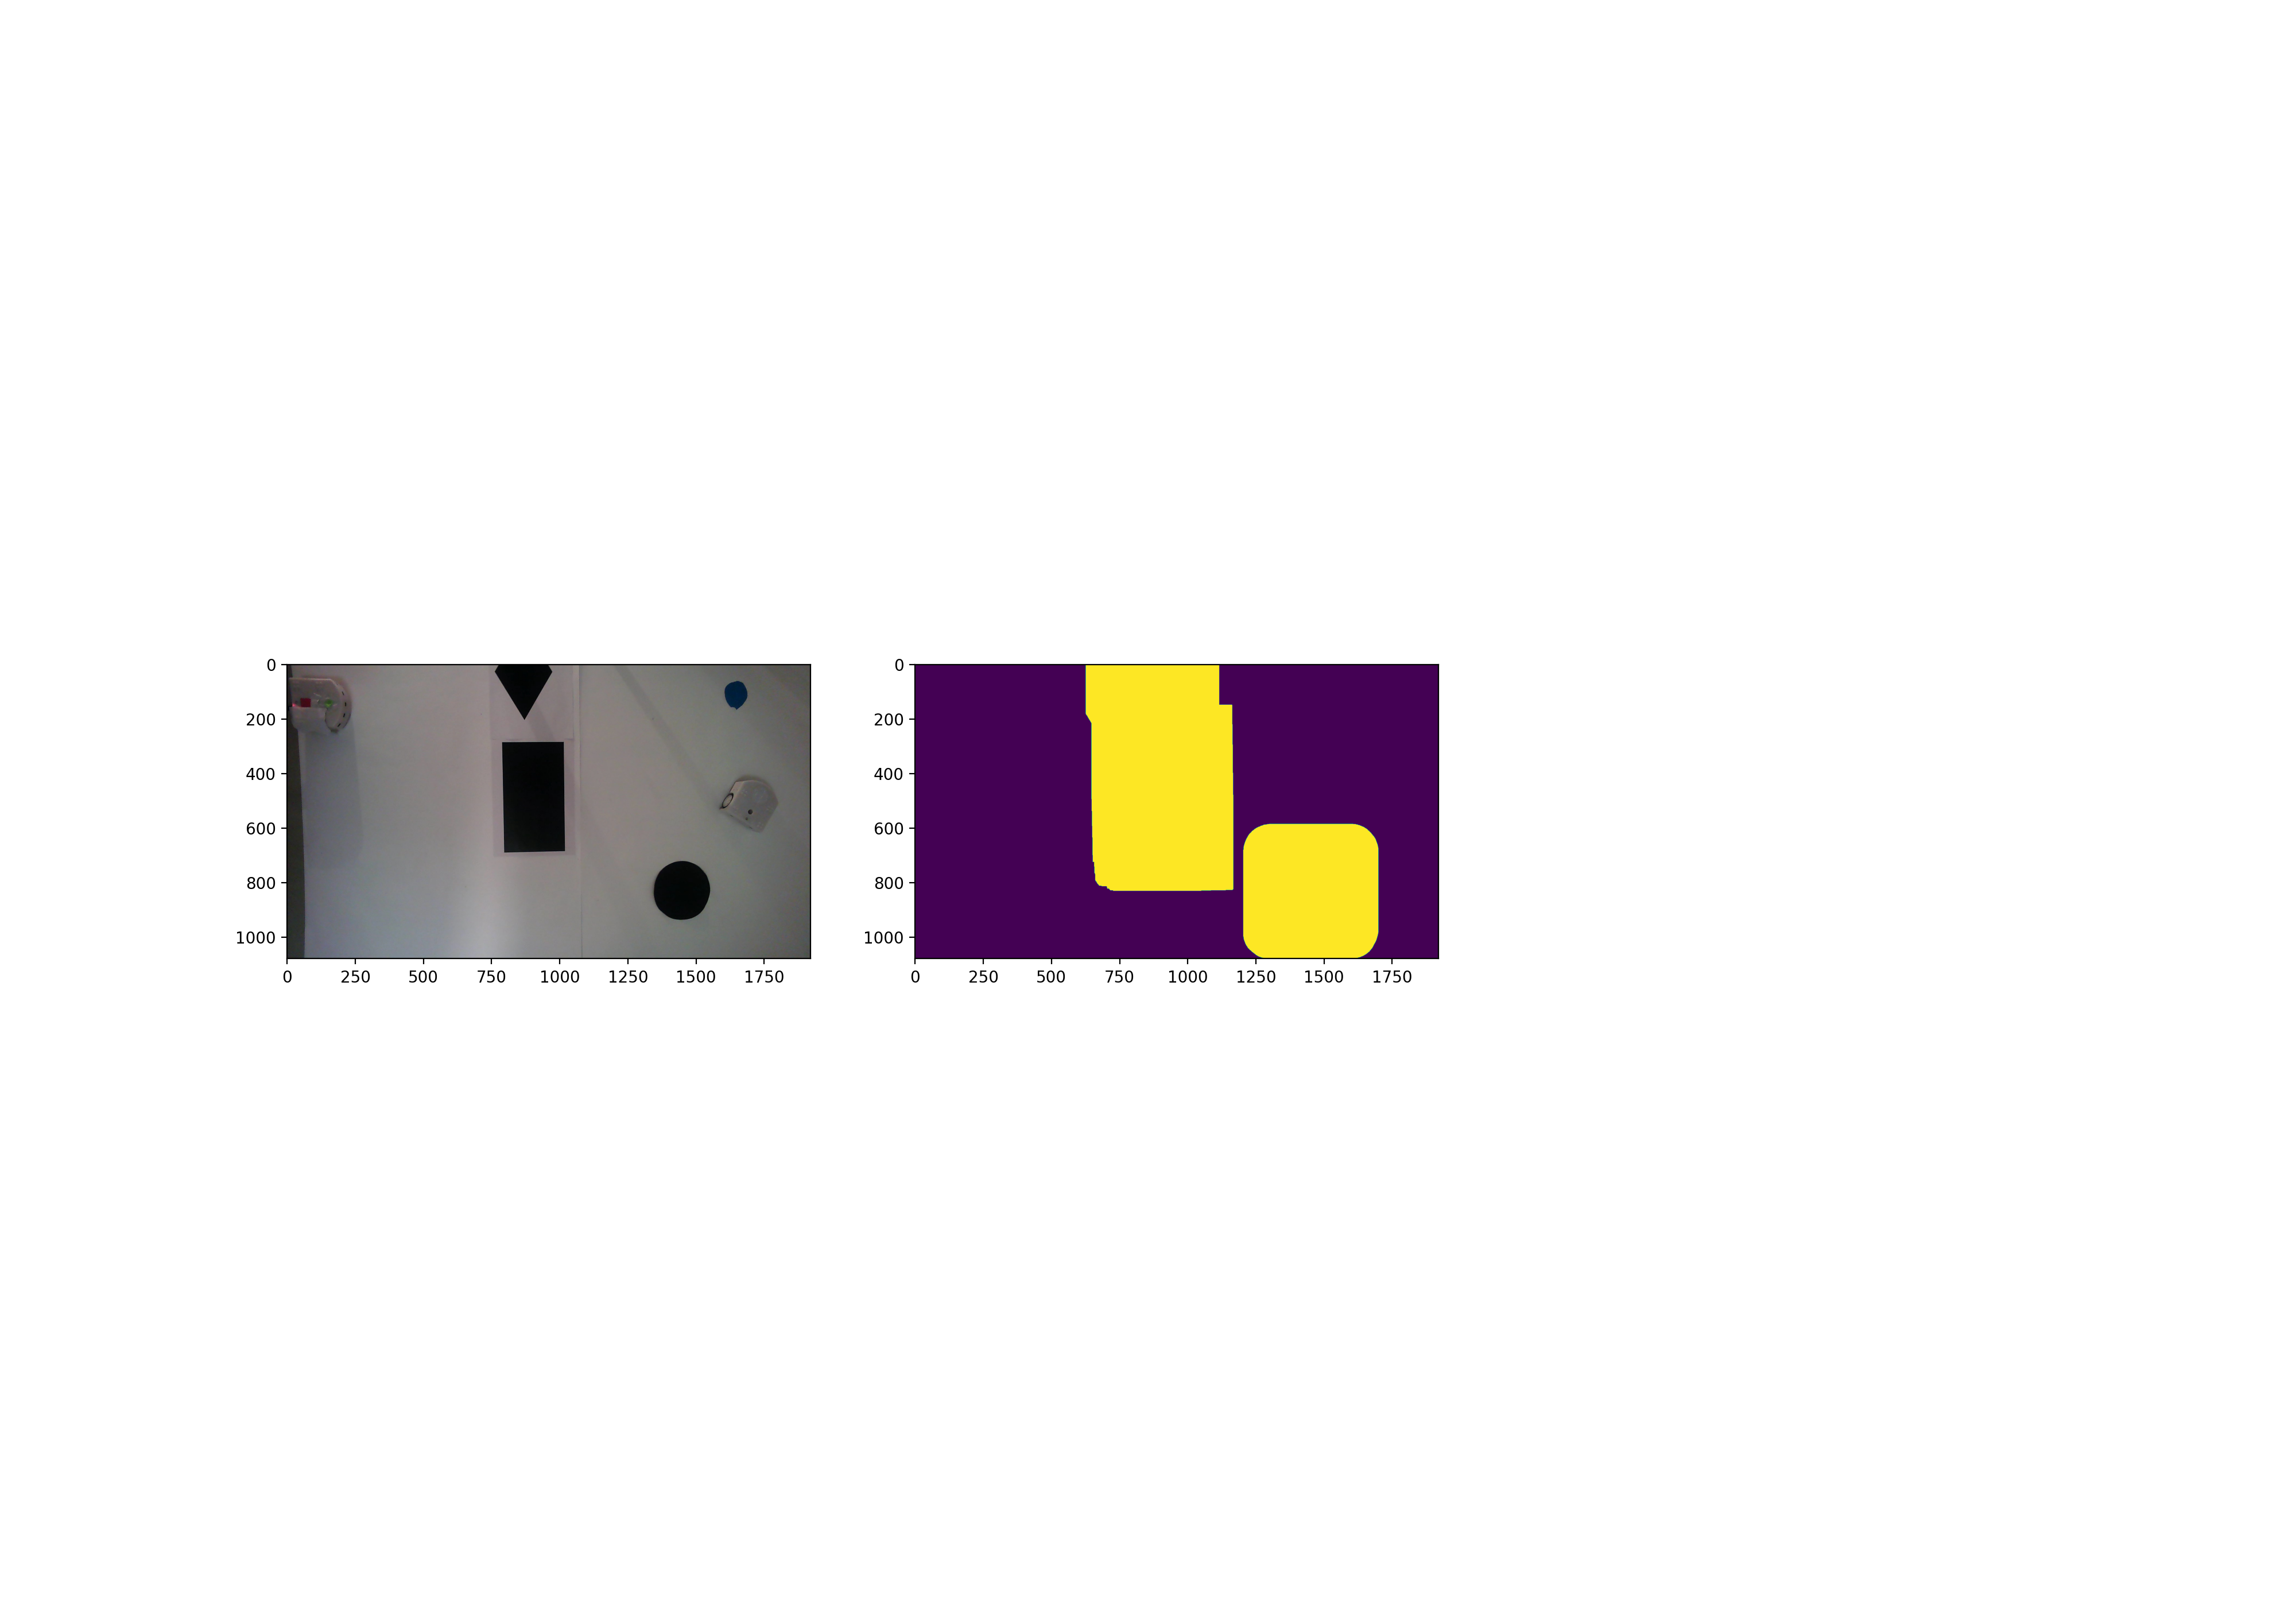

In [5]:
out=cv2.imread('capture.jpg')

# Mask for black obstacles 
lower_dark = np.array([0,0,0])
higher_dark = np.array([25,25,25])
mask=cv2.inRange(out,lower_dark,higher_dark)
mask=cv2.GaussianBlur(mask,(5,55),0)
ret, mask = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)

result=cv2.bitwise_and(out,out,mask=mask)
kernel = np.ones((50,50),np.uint8)
fin = cv2.dilate(mask, kernel, iterations = 6)
fig = plt.figure(figsize=(20, 14))
columns=3
fig.add_subplot(1, columns, 1)
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB)) 
fig.add_subplot(1, columns, 2)

plt.imshow(fin)

## Detection of start and goal <a name="start"></a>

The next step is to create a mask for each of the other colors: blue for the goal, and red/green for Thymio. The start will be the center of the green and red point that are placed on top of the robot as explained earlier. For these masks the image is converted to HSV but the principle is the same as previously.

We initialize the masks for our different colours.

__The variables are__:
- __lower1 and upper1 or lower2 and upper2__: the lower and higher boundaries for the red colour in HSV
- __low_green and high_green__: the lower and higher boundaries for the green colour in HSV
- __low_blue and high_blue__: the lower and higher boundaries for the blue colour in HSV

__Note__: The HSV space correspond to a cylinder, and the red color is distributed around the initial coordinate at both side, that is why there are four boundaries for the red color compared to two for the other colors.

In [6]:
# Initialisation

low_green = np.array([40, 55, 70]) 
high_green = np.array([102, 255, 255]) 

low_blue = np.array([96, 100, 50])
high_blue = np.array([126, 255, 255])

# lower boundary RED color range values; Hue (0 - 10)
lower1 = np.array([0, 100, 20])
upper1 = np.array([10, 255, 255])
 
# upper boundary RED color range values; Hue (160 - 180)
lower2 = np.array([160,100,20])
upper2 = np.array([179,255,255])
 
#Initial position of the green and red dot on the Thymio
pt_thymio_red0= np.zeros(2,) 
pt_thymio_green0 = np.zeros(2,) 

<a name="cen"></a>To get the start and arrival of the points of interest, we need to calculate the centroids of the colour masks, in a similar way as it is done in the correction of the second exercise session. This is implemented in the *for c in contours_* loops.

The calculation of the centroids require the calculation of the image moments which can be acquired thanks to the cv2.moments function, the theory used in the loops can be resumed by these two equations:

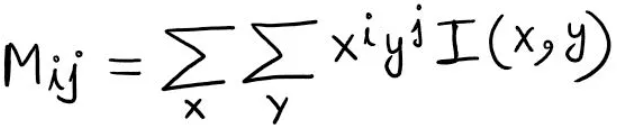 

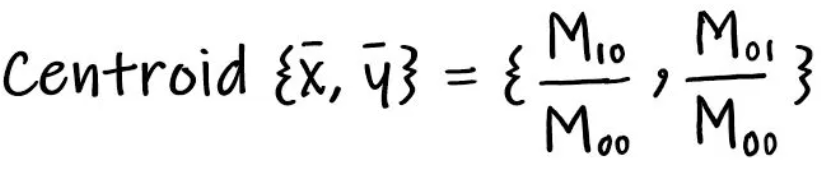

The first loop is done to find the Thymio position via the red point, the second one via the green point, and the third loop is used to find the blue goal.

In [7]:
cap = cv2.VideoCapture(0)
while True:
    _, frame = cap.read()
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
#1. Find the position of the Thymio
    # RED DOT

    lower_mask = cv2.inRange(hsv_frame, lower1, upper1)
    upper_mask = cv2.inRange(hsv_frame, lower2, upper2)
    red_mask = lower_mask + upper_mask;
    red = cv2.bitwise_and(frame, frame, mask=red_mask)
    contours, hierarchy = cv2.findContours(red_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        
        area = cv2.contourArea(c)
        if area > 300:
            cv2.drawContours(frame,[c],-1,(0,0,255), 3)
            M = cv2.moments(c)
            cx_red = int(M["m10"]/ M["m00"])
            cy_red = int(M["m01"]/ M["m00"])
            cv2.circle(frame,(cx_red,cy_red),7,(255,255,255),-1)
            pt_thymio_red0 =  [cx_red, cy_red]
                    

    # GREEN DOT:

    green_mask = cv2.inRange(hsv_frame, low_green, high_green)
    green = cv2.bitwise_and(frame, frame, mask=green_mask)
    contours, hierarchy = cv2.findContours(green_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        
        area = cv2.contourArea(c)
        if area > 300:
            cv2.drawContours(frame,[c],-1,(0,0,255), 3)
            M = cv2.moments(c)
            cx_green = int(M["m10"]/ M["m00"])
            cy_green = int(M["m01"]/ M["m00"])
            cv2.circle(frame,(cx_green,cy_green),7,(255,255,255),-1)
            pt_thymio_green0 =  [cx_green, cy_green]
            
              
#2. Find the goal
    # Track blue:
    
    blue_mask = cv2.inRange(hsv_frame, low_blue, high_blue)
    blue = cv2.bitwise_and(frame, frame, mask=blue_mask)
    contours, hierarchy = cv2.findContours(blue_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        
        area = cv2.contourArea(c)
        if area > 300:
            cv2.drawContours(frame,[c],-1,(255,0,0), 3)
            M = cv2.moments(c)
            cxb = int(M["m10"]/ M["m00"])
            cyb = int(M["m01"]/ M["m00"])
            cv2.circle(frame,(cxb,cyb),7,(255,255,255),-1)
            goal_pix = [cxb, cyb]
        
    cv2.imshow("result",frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print(goal_pix)
        break
    

[1645, 111]


There are two different colors on Thymio, green in the front and red in the back so that the orientiation can be calculated. The position of Thymio corresponds to the average of these two colors.

In [8]:
# Initial position of the Thymio / starting point
start_pix = [round((pt_thymio_green0[0] + pt_thymio_red0[0])/2), round((pt_thymio_green0[1] + pt_thymio_red0[1])/2)]
print(start_pix)

[110, 143]


At the beginning of the path finding the mask of the obstacles is resized so that it is less computationally demanding, therefore the localisations calculated with the centroids need to be rescaled. The function round is used in order to have an integer.

In [9]:
#Rescale of the coordinates:
xgoal = round(goal_pix[0]/30)
ygoal = round(goal_pix[1]/30)

xstart = round(start_pix[0]/30)
ystart = round(start_pix[1]/30)

goal = (ygoal,xgoal)
start = (ystart,xstart)

## Discussion <a name="visiondiscus"></a>

This section showed how the environnement and the program have been optimized to have a good and efficient computer vision. The choice of the colors is a key part in this project because in this case it is the foundation of the image analysis. Other tools have been used like the calculation of the centroids and the use of a gaussian blur to allow the rest of the program to have access to enough data concerning the thymio.

The detection of the goal and the starting position is sensible and dependent to light and the conditions of the room we are in. 

## 3. Global navigation <a name="globalnav"></a>

The global navigation is the primary type of navigation, and the one that should be used most of the time by the robot. It is a pathfinder that is called at the beginning. The path is determined by the map of the obstacles and the localisation of the starting point of the Thymio and the arrival.

__Input__: a map which is the mask of obstacles, the localisation of the starting point of the thymio and the arrival

__Output__: the path to follow

The functions implemented to do so are: 

- __pix_to_cm__: a function that converts pixels to centimeters, useful for the checkpoints
- __create_empty_plot__: a helper function to create a figure of the desired dimensions & grid, we want a figure of 36x64
- __get_movements__: get all the connectivity movements (4 or 8)
- __reconstruct_path__: recurrently reconstructs the path from start node to the current node
- __A_star__: A* for 2D occupancy grid. Finds a path from start to goal. h is the heuristic function. h(n) estimates the cost to reach goal from node n.

## Creation of the grid <a name="grid"></a>

For our grid we chose to do an approximate cell decomposition, as it is well-adapted to the complexity of the environment and allows us to use a connectivity graph. It is mathematically more difficult than a roadmap, but, it is complete: if a free path exists, the cell decomposition will find it. 

In [16]:
dim = (64,36) #(64,36)

mask_noir = cv2.resize(fin, dim, interpolation = cv2.INTER_AREA)
max_valx = 36
max_valy = 64

data = np.array(mask_noir) #hough_maxima


limit = 250
occupancy_grid = data.copy()
occupancy_grid[data>limit] = 1
occupancy_grid[data<=limit] = 0

def create_empty_plot(max_valx, max_valy):
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticksx = np.arange(0, max_valx+1, 5)
    minor_ticksx = np.arange(0, max_valx+1, 1)
    
    major_ticksy = np.arange(0, max_valy+1, 5)
    minor_ticksy = np.arange(0, max_valy+1, 1)
    
    ax.set_xticks(major_ticksx)
    ax.set_xticks(minor_ticksx, minor=True)
    ax.set_yticks(major_ticksy)
    ax.set_yticks(minor_ticksy, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_valy])
    ax.set_xlim([-1,max_valx])
    ax.grid(True)
    
    return fig, ax

Here is an example of a map created by the steps descibed in the image analysis part, the dilated obstacles are in yellow. The first step is to resize to a 64 by 36 image. The goal is to make an occupancy grid where one pixel corresponds to one box of the grid. Resizing allows to have an occupancy grid with 9000 times less boxes, helping the pathfinding to be less computationally demanding. 

<div>
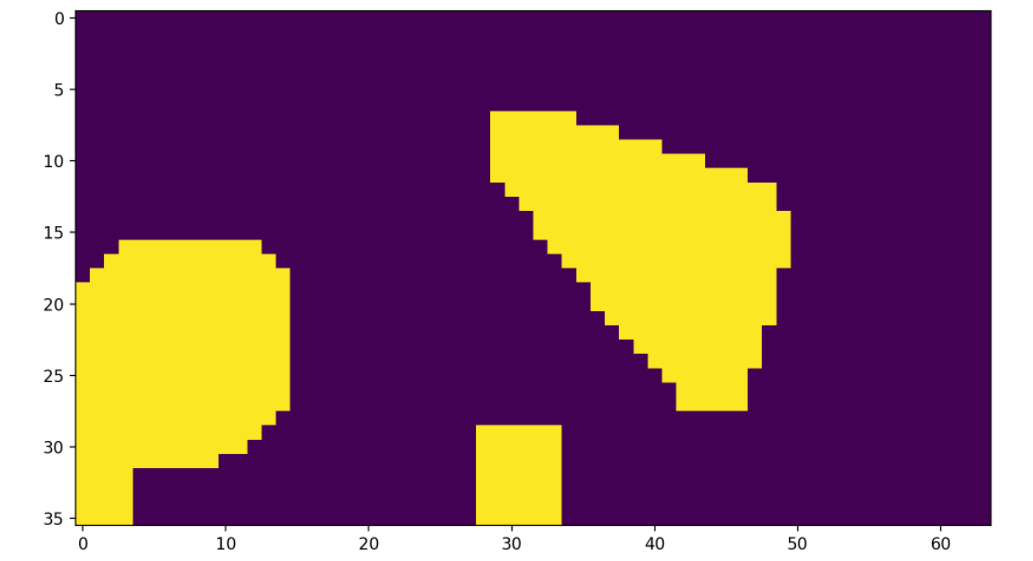
</div>

## A* <a name="astar"></a>

The path finding is done thanks to an A* algorithm with all possible 8-connectivity movements similarly to the exercise session 5. Our occupancy grid is a rectangle.

A* was chosen because it optimizes the search instead of exploring all possible paths (like in the Dijkstra algorithm), it gives priority to nodes that are supposed to be better, and it works perfectly with the approximate cell decomposition.

In [17]:
def _get_movements_4n():
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0)]

def _get_movements_8n():
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

In [18]:
def reconstruct_path(cameFrom, current):
    total_path = [current]
    while current in cameFrom.keys():#COOOL
        #Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) #j'assigne à la position 0 à chaque fois.
        current=cameFrom[current]
    return total_path


def A_Star(start, goal, h, coords, hough_maxima, movement_type="8N", max_valy = max_valy):
    
    # Check if the start and goal are within the boundaries of the map
    for point in [start, goal]:
        for coord in point:
            assert coord>=0 and coord<max_valy, "start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]: #je pense = 1 si  obstacle
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    if movement_type == '4N':
        movements = _get_movements_4n()
    elif movement_type == '8N':
        movements = _get_movements_8n()
    else:
        raise ValueError('Unknown movement')
    
    # Here we initialise the variables
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict() #camefrom le (x,y) sur le chemin optimal juste avant le node n = (currentx, currenty)

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))])) #il donne la valeur infini à chaque coordonnées
    fScore[start] = h[start] #ce h il vaut combien => on l'a calculé au départ
#range creer tableau de longueur len(coords)
    
    # while there are still nodes to visit

    while openSet != []:
        
            
        min = np.inf
        for p in openSet:
            if fScore[p] < min: #ici je vais reach for celui qui a le plus petit fScore et donc hScore
                min = fScore[p] 
                current = p
                
        #np.delete(openSet, current)
        #np.append(ClosedSet, current)
        
        openSet.remove(current)
        closedSet.append(current)
    
        #If the goal is reached, reconstruct and return the obtained path
        
        if current == goal: #ecriture vectorisé
            return reconstruct_path(cameFrom,current), closedSet

        # If the goal was not reached, for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] <0) or (neighbor[1] <0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0],neighbor[1]] == 1) or (neighbor in closedSet):
                continue
                
            # compute the cost to reach the node through the given path
            
            tentative_gScore = gScore[current] + deltacost
            
            # Add the neighbor list of nodes who's neighbors need to be visited
            if neighbor not in openSet:
                openSet.append(neighbor)
            
            
            # If the computed cost if the best one for that node, then update the costs and 
            # node from which it came
            if tentative_gScore < gScore[neighbor]: #gScore[neighbor] a une valeur infinie
 
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current #j'ai l'impression que tout les neighbors de current seront dans camfrom hors on veut ceux qui on la plus faible f value
                gScore[neighbor] = tentative_gScore 
                fScore[neighbor] = gScore[neighbor] + h[neighbor]  #ici je compute le fscore pour tout les neighbors et plus loin je vais chercher le fscore plus petit qui va devenir current
                
                

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet                                                  

In [19]:
#conversion pixels en cm
def pix_to_cm(point_rouge1, point_rouge2, point):
    
    norme_rouge = np.sqrt((point_rouge2[0] - point_rouge1[0])**2 + (point_rouge2[1]- point_rouge1[1])**2)
    point = np.array(point)*(5/norme_rouge)
    
    return point

Having a path constructed with an occupancy grid can lead to movement that is not smooth if there are a lot of direction changes. We have chosen to create a "checkpoint" each time the trajectory changes in direction.

In [20]:
# List of all coordinates in the grid
x,y = np.mgrid[0:occupancy_grid.shape[0]:1, 0:occupancy_grid.shape[1]:1] 
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
coords = list([(int(x[0]), int(x[1])) for x in pos])

# Define the heuristic, here = distance to goal ignoring obstacles
h = np.linalg.norm(pos - goal, axis=-1) 
h = dict(zip(coords, h)) # cool

# Run the A* algorithm
path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid, movement_type="8N")


# Creating checkpoints
checkpoint = []
direction = []
for x in range(1,len(path)):
    v = np.array(path[x]) - np.array(path[x-1])
    direction.append(v)

    
for x in range(1,len(path)-1):
    if ((direction[x-1][0] != direction[x][0]) | (direction[x-1][1] != direction[x][1])):
               checkpoint.append(path[x])

checkpoint.append(goal)
            
checkpoint_2 = np.array(checkpoint).reshape(-1, 2).transpose()

path = np.array(path).reshape(-1, 2).transpose()
visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

<IPython.core.display.Javascript object>


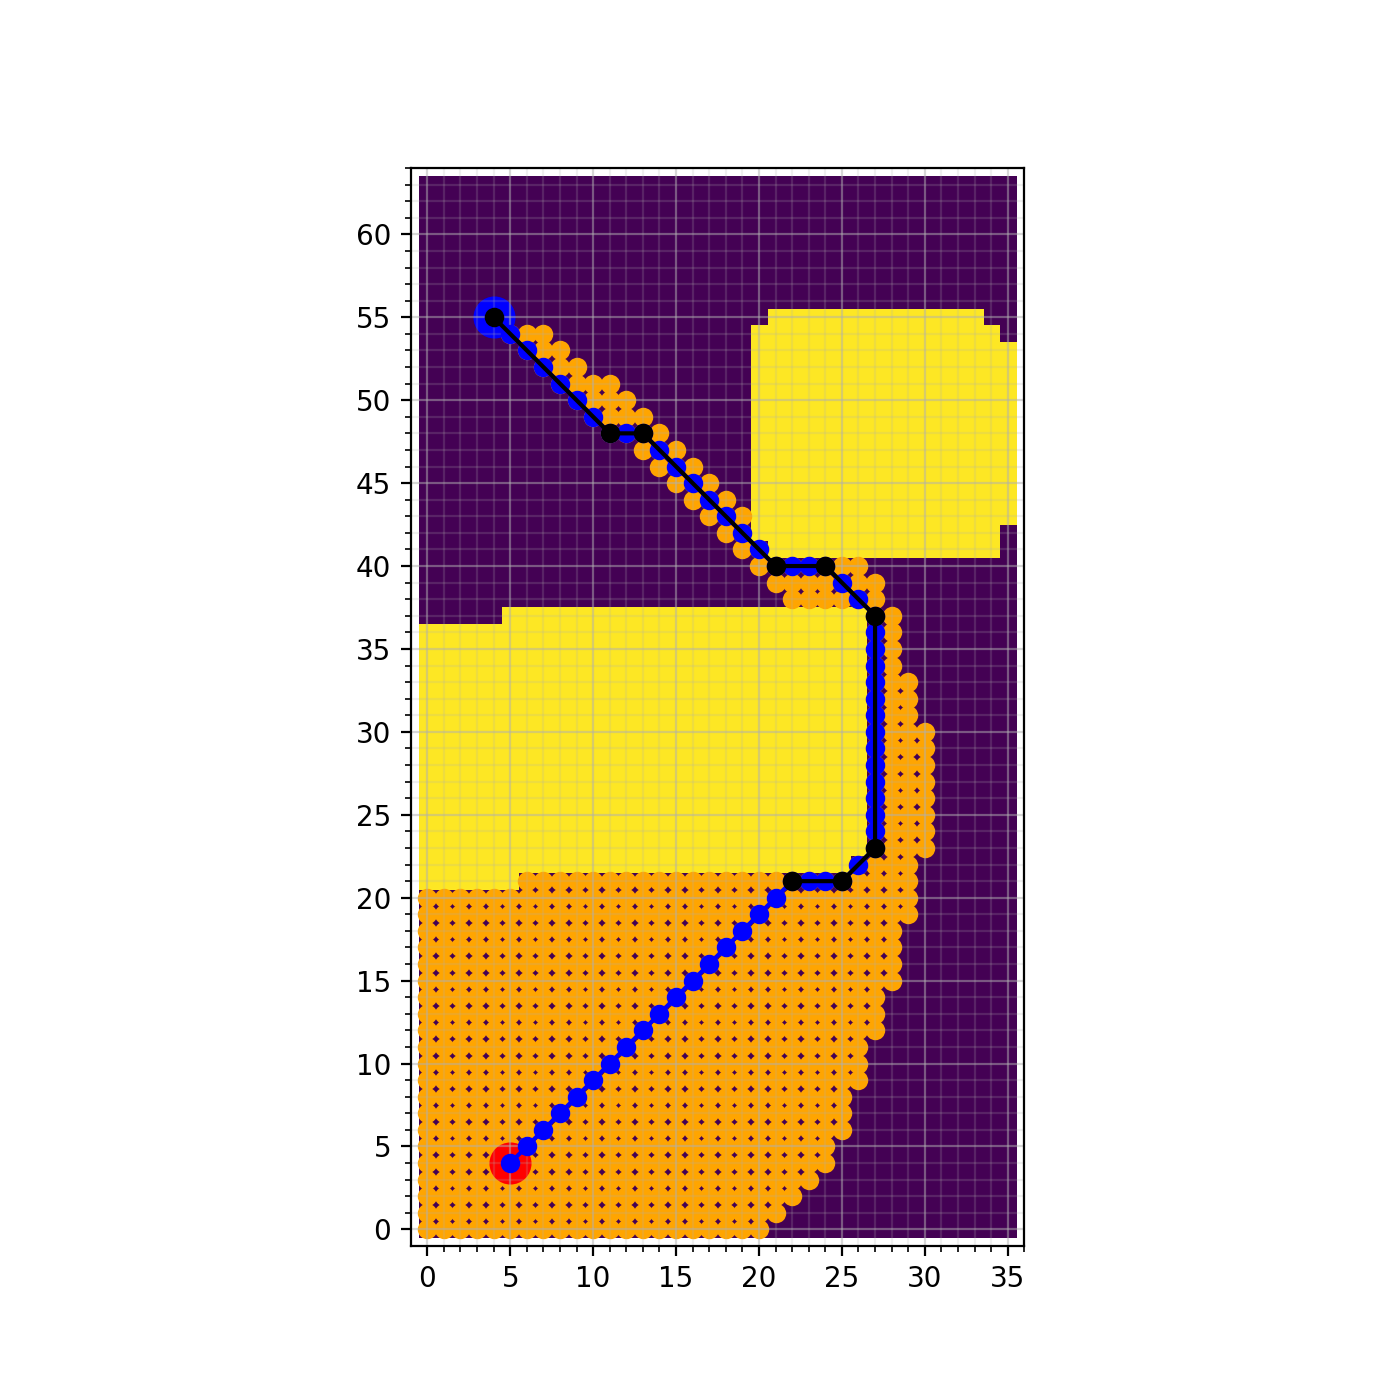

In [21]:
# Displaying the map
# Blue cicle: the goal 
# Red cicle: the starting point / inital position of the Thymio
# Blue dot: path generated by A* algorithm 
# Black dot: checkpoints

fig_astar, ax_astar = create_empty_plot(36, 64)

ax_astar.imshow(occupancy_grid.transpose(), origin='upper')
ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
ax_astar.plot(checkpoint_2[0], checkpoint_2[1], marker="o", color = 'black');
ax_astar.scatter(start[0], start[1], marker="o", color = 'red', s=200);
ax_astar.scatter(goal[0], goal[1], marker="o", color = 'blue', s=200);

So that the trajectory can be mostly straight, we try to reduce the number of checkpoints by setting a minimum distance between them.

In [22]:
# Smoothing the path

#----
# Initialisation

# Non rescaled checkpoints (used to plot the new trajectory in the next cell)
new_checkpoint_2_x = checkpoint_2[0]
new_checkpoint_2_y = checkpoint_2[0]

#rescaling the coordinates of the checkpoints
upsized_checkpoint =  [i * 30 for i in checkpoint_2] 

# Converting the checkpoints in cm
checkpoint_cm = pix_to_cm(pt_thymio_red0, pt_thymio_green0,upsized_checkpoint)

x = checkpoint_cm[0]
y = checkpoint_cm[1]


# ------
# We compute the distance between two consecutive checkpoints and erase one 
# if the distance is smaller than 5 cm

var = [] #contains the indexes of the checkpoints we want to erase

for j in range(0, len(checkpoint_cm[0])-2):
    dist_current = np.sqrt((checkpoint_cm[0][j+1] - checkpoint_cm[0][j])**2 + (checkpoint_cm[1][j+1] - checkpoint_cm[1][j])**2)
    if dist_current < 5:
        var.append(j+1)   
                
# ----
# Results

new_checkpoint_x_cm = np.delete(x, var)
new_checkpoint_y_cm = np.delete(y, var)

new_checkpoint_x = np.delete(upsized_checkpoint[0], var)
new_checkpoint_y = np.delete(upsized_checkpoint[1], var)

new_checkpoint_2_x=np.delete(checkpoint_2[0], var)
new_checkpoint_2_y=np.delete(checkpoint_2[1], var)


<IPython.core.display.Javascript object>


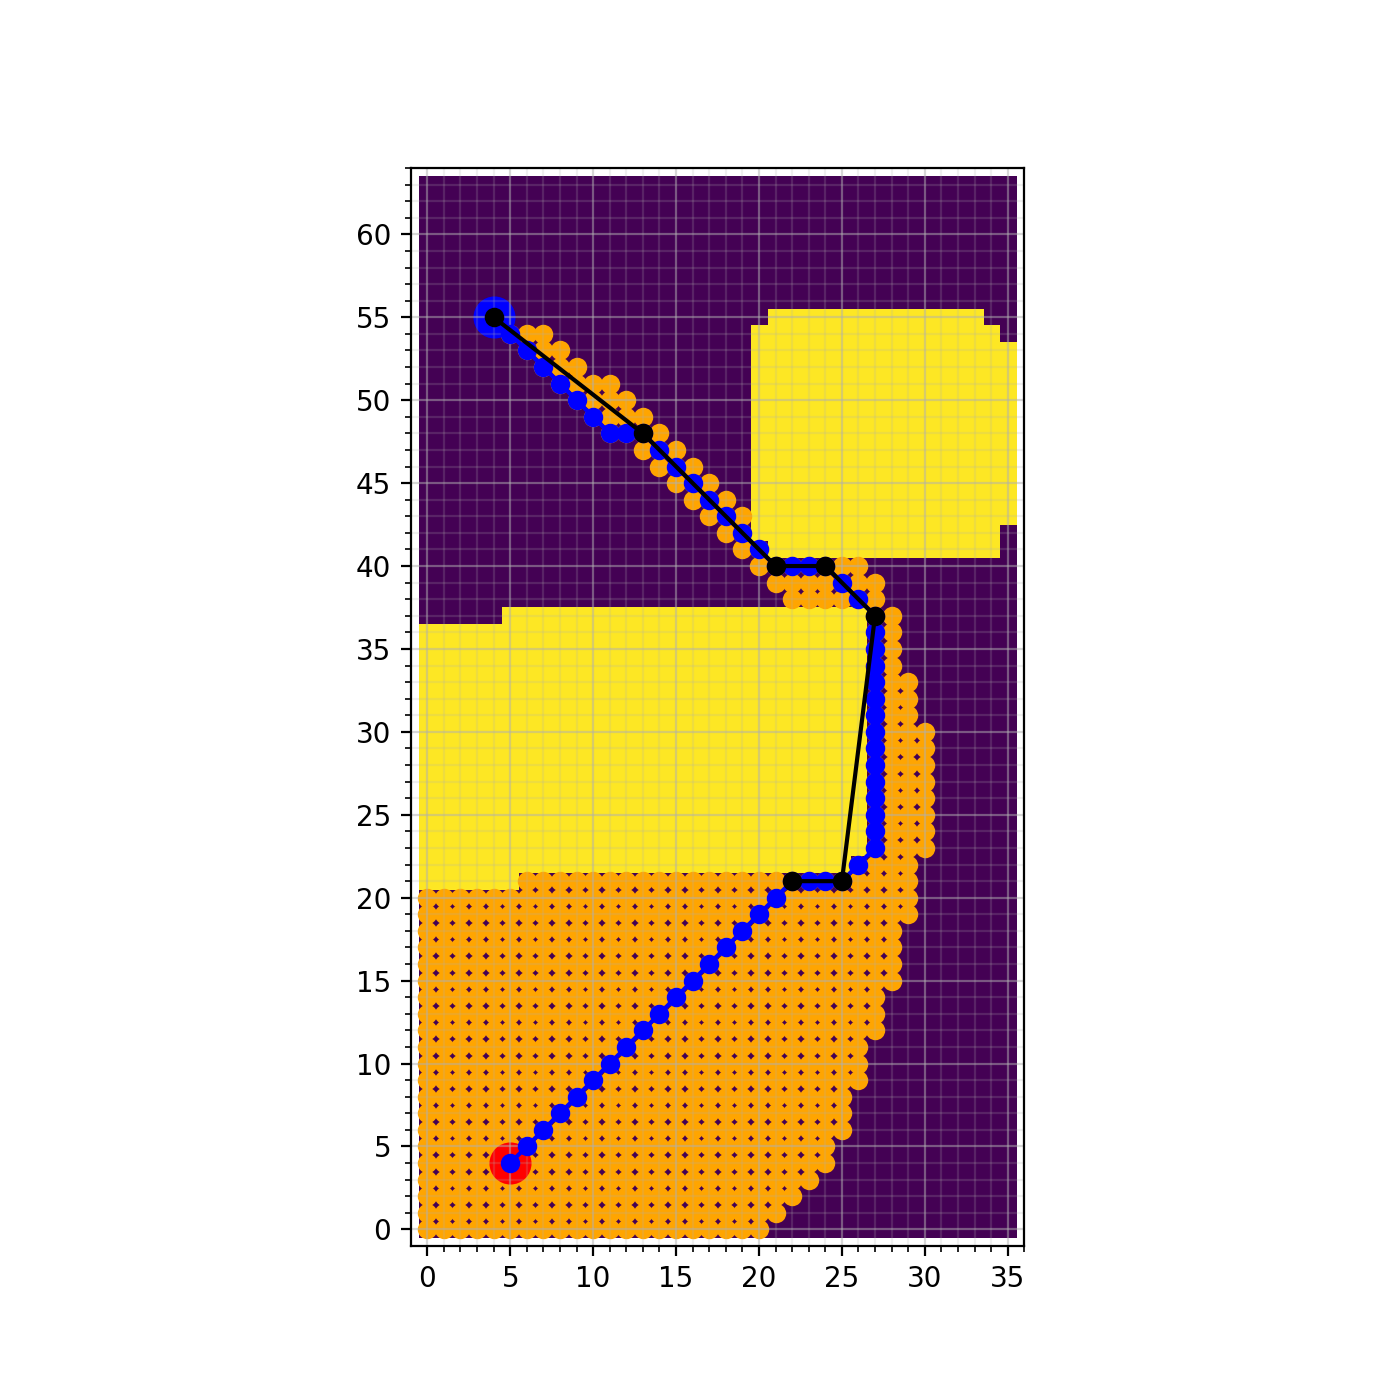

In [23]:
# Displaying the map
# Blue cicle: the goal 
# Red cicle: the starting point / inital position of the Thymio
# Blue dot: path generated by A* algorithm 
# Black dot: checkpoints
fig_astar, ax_astar = create_empty_plot(36, 64)

ax_astar.imshow(occupancy_grid.transpose(), origin='upper')
ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
ax_astar.plot(new_checkpoint_2_x, new_checkpoint_2_y, marker="o", color = 'black');
ax_astar.scatter(start[0], start[1], marker="o", color = 'red', s=200);
ax_astar.scatter(goal[0], goal[1], marker="o", color = 'blue', s=200);

## Discussion <a name="globaldis"></a>

Using the approximate cell decomposition proves itself to be very efficient, it does indeed always find a path, when possible, thanks to the heuristic function. Reducing the number of checkpoints is an essential step: it allows a better and easier control of the robot, plus a smoother motion.

## 4. Local Navigation<a name="loc"></a>

## Obstacle avoidance <a name="obstacleavoidance"></a>

The goal of the local navigation is to avoid objects that can be placed on Thymio's path during the global navigation. Our goal is the following: Thymio has to detect, avoid the obstacle and go back on his initial path.

__Inputs__: proximity sensors values

__Outputs__: motors values

__The variables used are:__
- __speedGain__: it is the speed proportional factor for the wheels
- __obstThrH__: it is the obstacle threshold to switch states
- __obstSpeedGain__: it is the gain when turning the wheels
- __Ul, Ur__: the speeds sent to the motor when switches are made
- __tourne_g__: it's a state that defines whether the robot should turn left or not, depends on whether the obstacle is detected on the left or right of the robot.


The local navigation uses all proximity sensors positioned in front of the robot.
Here are the principal steps: 

1. Proximity sensors detection

If the value of at least one proximity sensor is bigger than the threshold value __obstThrH__, __state__ takes the value 1 and we enter into local navigation. The value __tourne_g__ takes the value 1 if proximity sensors 4 and 3 were active first. __tourne_g__ determines in which direction Thymio will turn in the turning step. We also check the distance between the robot position and the checkpoint, if this distance is small, we skip the checkpoint so we don't end up in an infinite local loop.

2. Contact avoidance

Thymio goes backwards with a speed proportional to the values the proximity sensors, using the factor __obstSpeedGain__.

3. Turning step

Once all proximity sensors values are back to zero, Thymio turns for a 90 degree angle to the left if  __tourne_g__ equals 1 or to the right otherwise.

4. Going forward step

Thymio goes straight for 8 seconds.

5. Leave local state

Before leaving the local state, we compare our current x position __Xr__ with the position of the checkpoint to reach __Xt[current]__. If __Xr__ > __Xt[current]__ , this means we passed the checkpoint during the obstacle avoidance routine. Thus, we increment __current__ in the aim to target the next checkpoint. We leave local navigation and go back to global navigation. 


__*The local navigation code can be observed in the [Overall implementation](#ov) code.*__

## Discussion <a name="locdiscus"></a>

Our local navigation fits well with the global navigation. One limit is that in local navigation Thymio does not avoid the obstacle in an optimal trajectory. An improvement might be to retake a picture of the map when proximity sensors are active and recalculate the optimal path using A* algorithm, but that would be SLAM.

## 5. Motion control<a name="mov"></a>

## Theory <a name="motiontheory"></a>

Our goal is to design a controller that will help us reach a desired position:
($X_t$, $Y_t$) given the position and orientation of the robot: ($X_r$, $Y_r$, $\theta_r$).


Thymio is a two-wheeled differentially driven nonholonomic mobile robot. There are many feedback controllers proposed in the literature. We decided to opt for an efficient and simple option to implement: proportional controllers. 

In order to reach the desired position, the robot can move in straight line with a speed $V_s$ or he can turn with a speed $V_t$. The following images illustrate the problem. 
We defined variables as follow: 
- $\Delta l$: the distance between the robot and the target. We want to minimize this distance.
$$\Delta l=\sqrt{ \Delta x^2 + \Delta y^2} $$    
- $\Delta \lambda$: the distance from Thymio to R, the nearest point from the desired reference that lies on the robot orientation line
- $\phi$: the angle of the vector that binds the robot position to the desired reference
- $\Delta \phi$: difference between the angle $\phi$ and the robot orientation $\theta_r$.
$$\Delta \phi= \phi - \theta_r$$

<div>
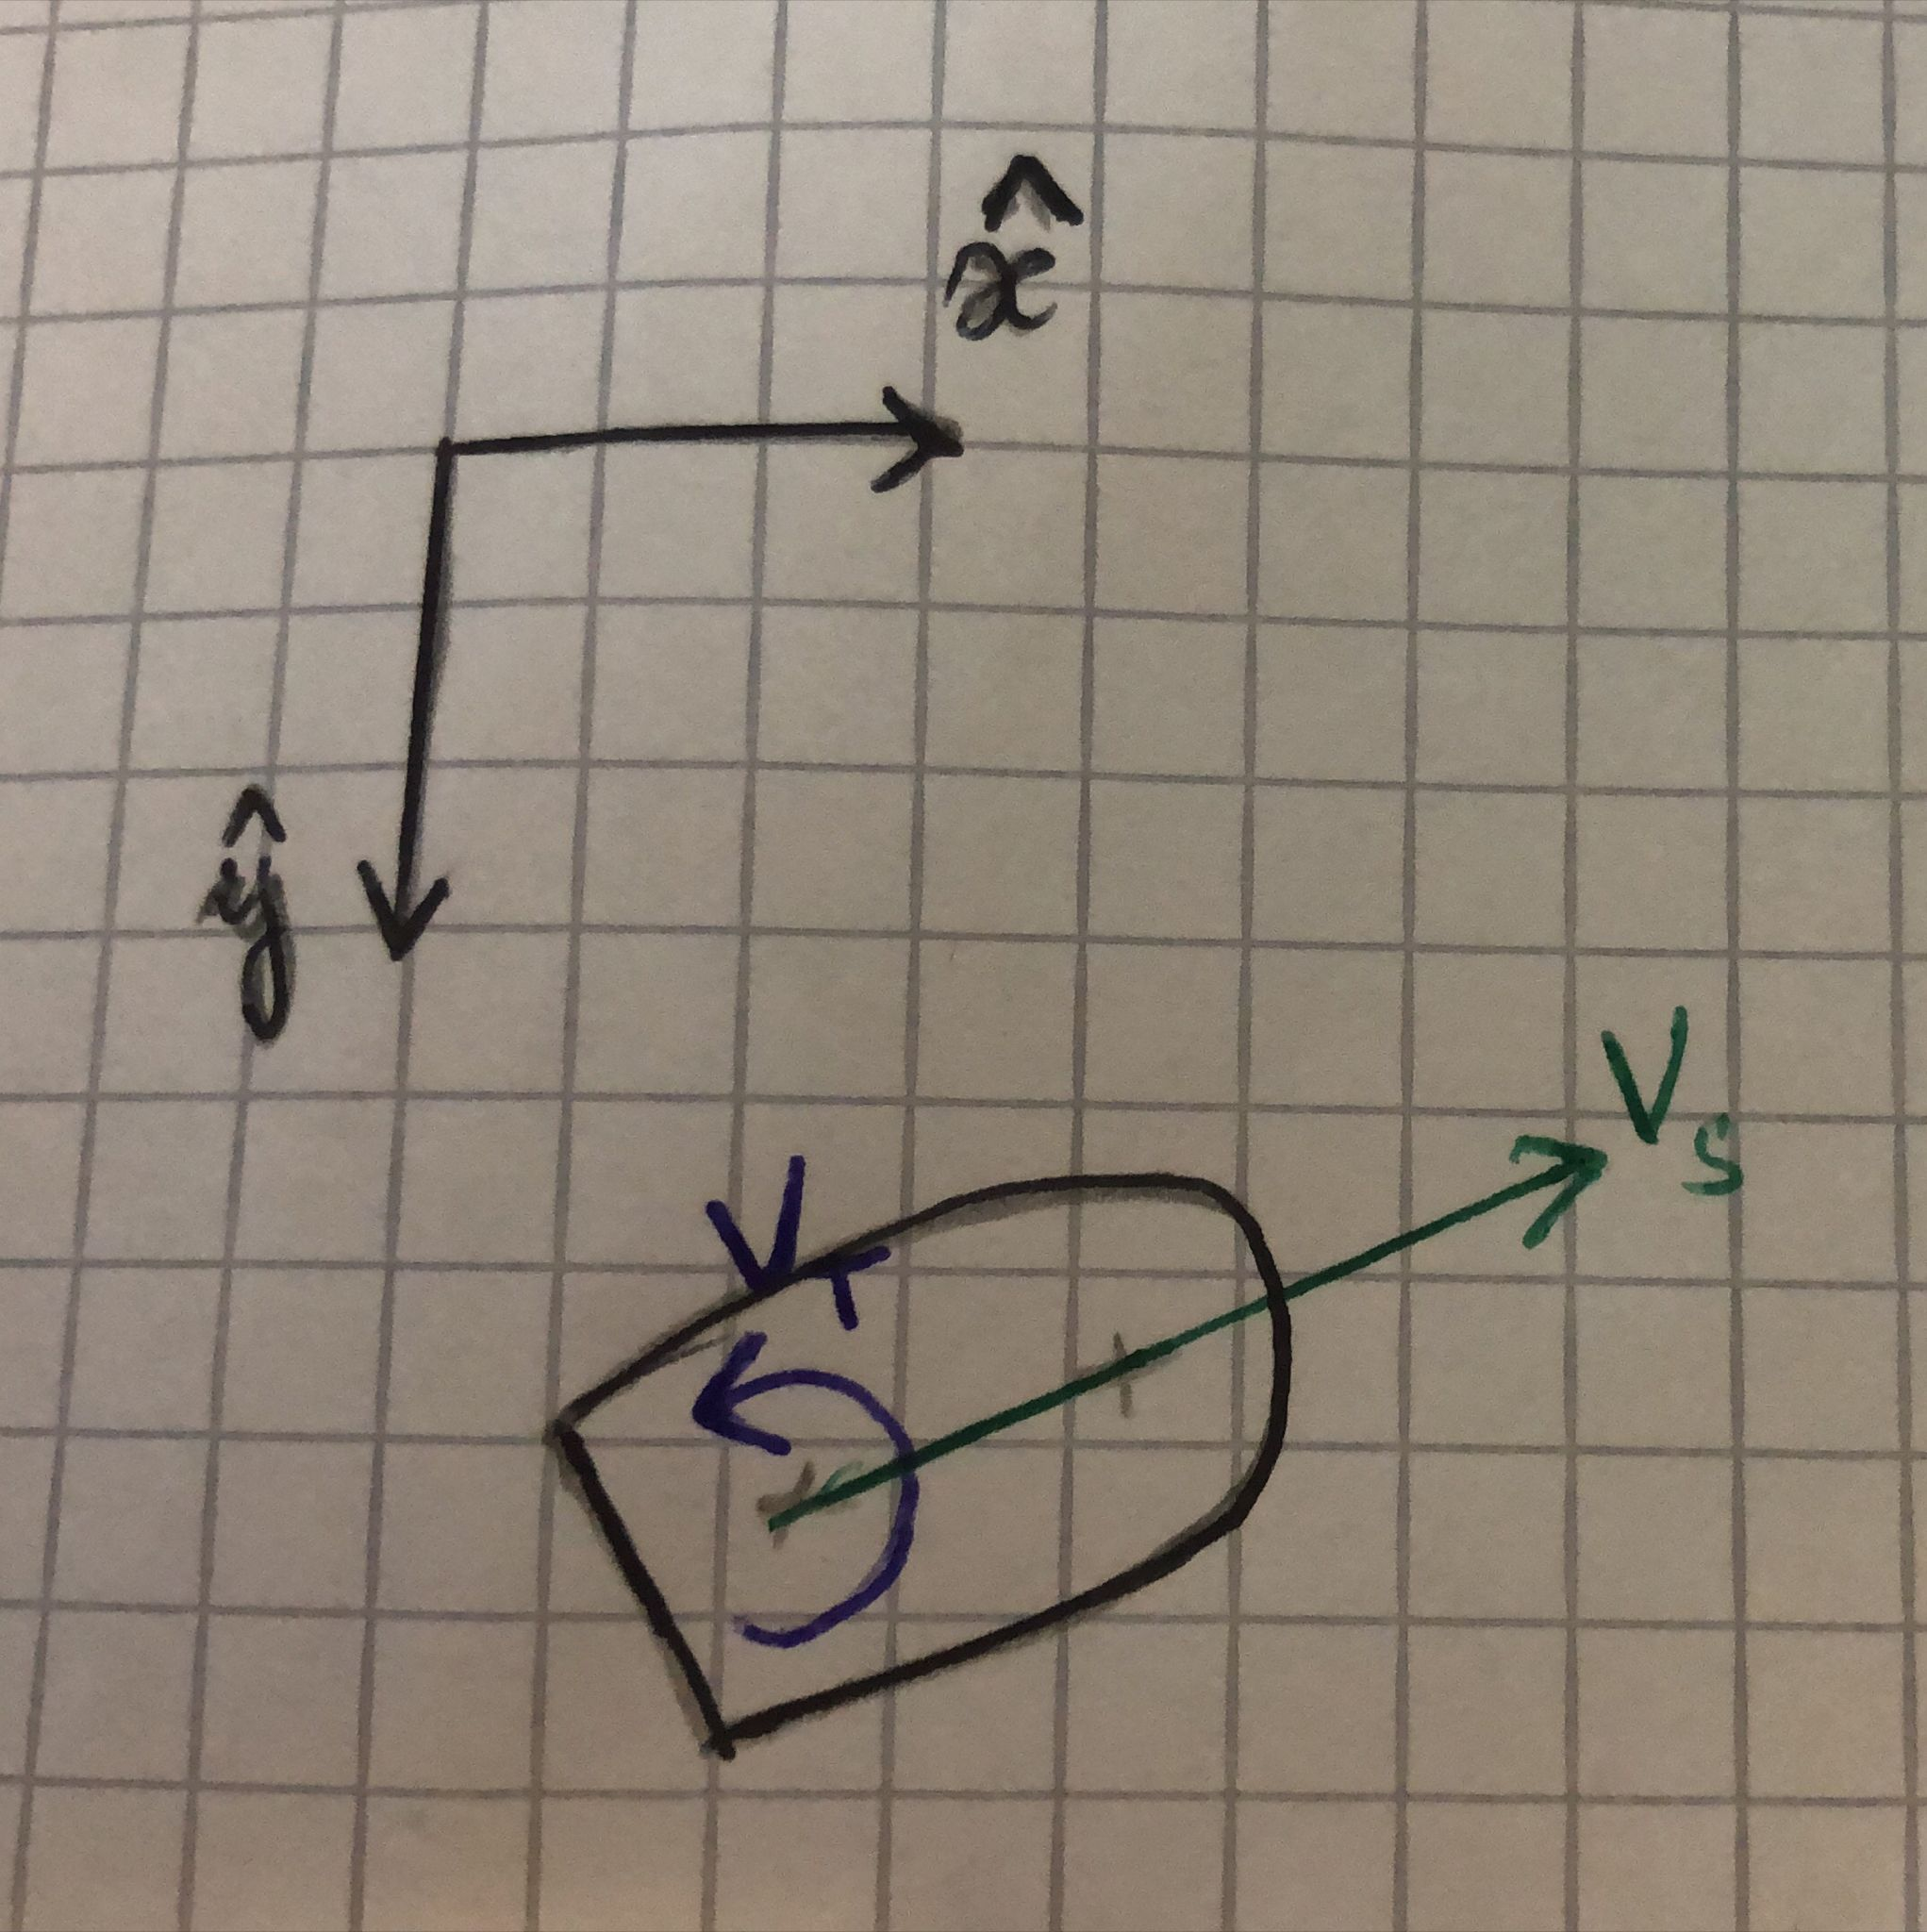
</div>


<div>
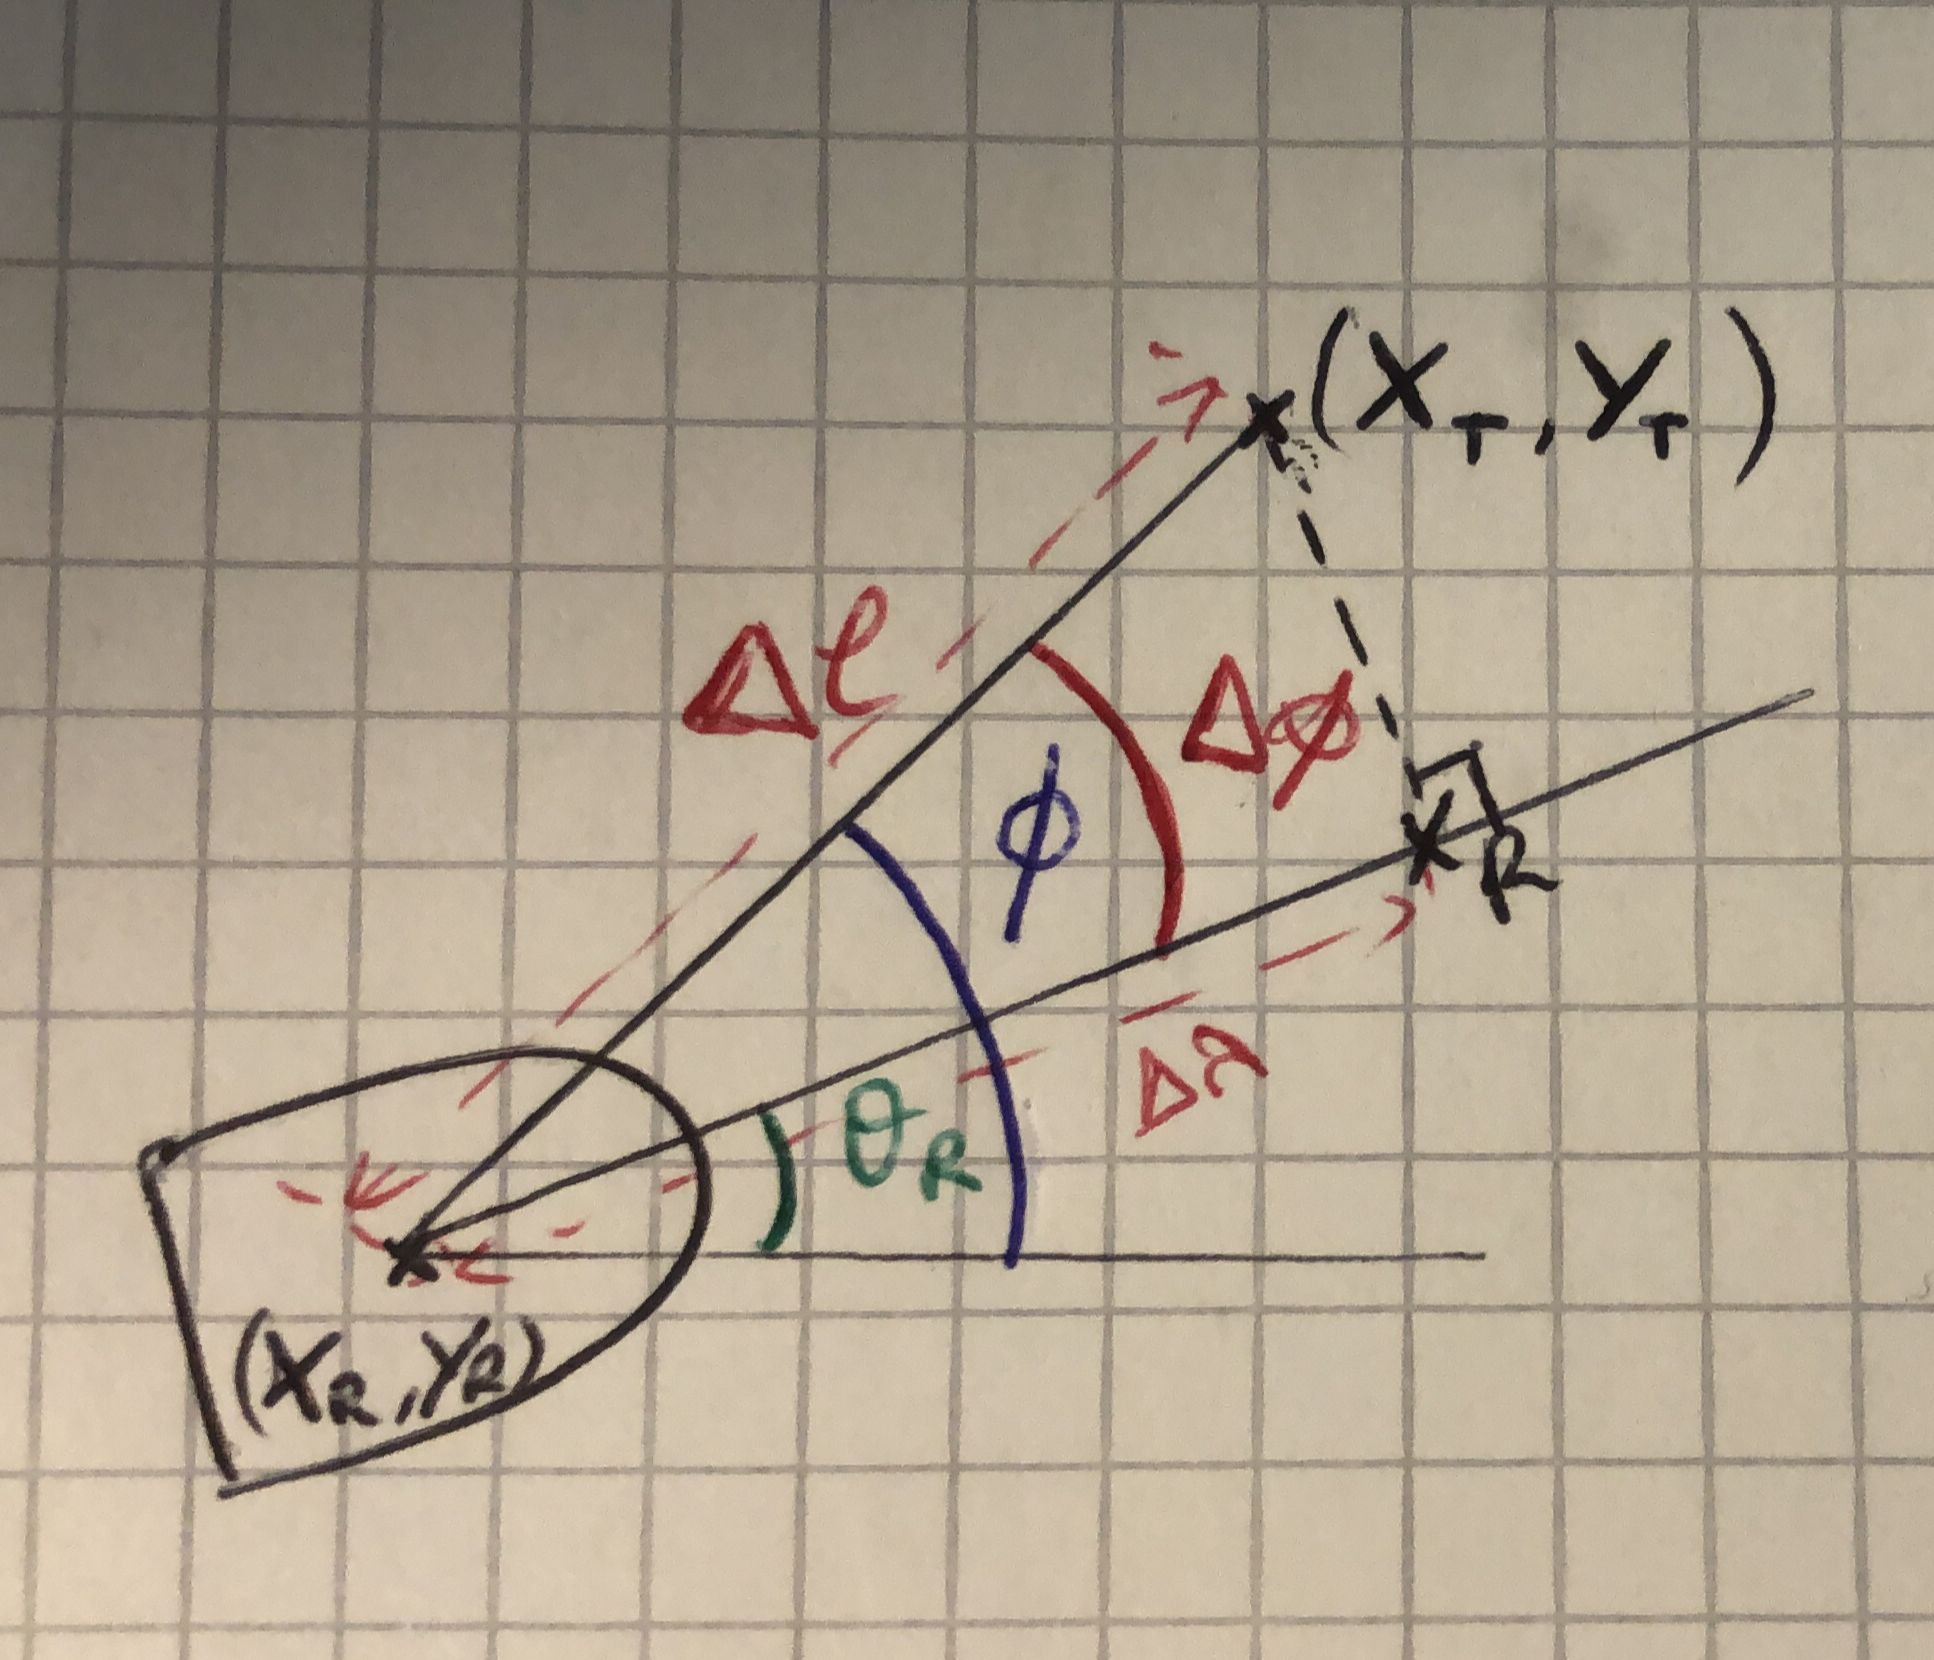
</div>

It is not trivial to minimize $\Delta l$. However, we can write:
$$ \Delta l = {\Delta \lambda \over cos(\Delta \phi)} $$

Thus, now, we only need to minimize $\Delta \lambda$ and $\Delta \phi$. To do so, we defined two proportional controllers minimizing:
- $E_s$ = $\Delta \lambda$= $\Delta l$ * cos($\Delta \phi$)
- $E_t$ = $\Delta \phi$

They determine the speeds $V_s$ and $V_t$:
- $V_s$ = $K_s$*$E_s$
- $V_t$ = $K_t$*$E_t$

With $K_s$ and $K_t$ constants to be defined experimentally.

However, we can only control the left ($U_l$) and right ($U_r$) speed of the motors of Thymio. The link between $V_s$, $V_t$, $U_r$ and $U_l$ is given by:

 - $U_l$ = $V_s$ - $V_t$
 - $U_r$ = $V_s$ + $V_t$



## Implementation <a name="motionimplementation"></a>

This part explains the implementation of the theory discussed in the previous part. Parameters had to be determined experimentally: $K_s$, $K_t$, $marge_s$ and $marge_t$. The margins: $marge_s$ and $marge_t$ define when we reach the target. We limited the  maximum value of the speed to ±350. If the errors are too big or small, the speed will not exceed ±350. We also added a minimum speed of 90. 

__Input__:
- position of the robot: $X_r$, $Y_r$
- orientation of the robot:  $\theta_r$
- position of the target: $X_t$, $Y_t$

__Output__:
- $U_l$: left speed of the motor
- $U_r$: right speed of the motor
- $E_s$: position error
- $E_t$: orientation error
- $\phi$: the orientation we want Thymio to have 

In [24]:
def controller(Xr, Yr, theta_r, Xt, Yt):
    Ul = 0
    Ur = 0
    marge_s= 40
    marge_t = 5   
    
    delta_Xref = Xt - Xr
    delta_Yref = Yt - Yr
    
    if delta_Xref != 0:
        # phi: the orientation we want to reach
        phi = round( np.rad2deg(np.arctan2(delta_Yref, delta_Xref)))
        
        # delta_phi: by how much the controller has to turn to reach the desired position
        delta_phi = (phi - theta_r)
        
    if delta_Xref == 0:
        delta_phi = 90 - theta_r
        phi = 90
    
    Ks = 0.3 
    Kt = 1.7
    
    # Angular error
    Et = round(delta_phi)
    
    if abs(Et)< marge_t:
        Et = 0
        
        
    # Position error
    Es = round(np.sqrt(delta_Xref**2 + delta_Yref**2 ) + np.cos(delta_phi))
    
    if abs(Es)< marge_s:
        Es = 0
        Et = 0
    
    #Proportional controllers 
    Vs = Ks*Es
    Vt = Kt*Et
    
    Ul = 90+round(Vs + Vt) #delta_phi / Et > 0 => Vt>0: on tourne à droite 
    Ur = 90+round(Vs - Vt)
    
    if Ul > 350:
        Ul = 350
        
    if Ur > 350:
        Ur = 350
        
    if Ul < -350:
        Ul = -350
    
    if Ur < -350:
        Ur = -350
    
    return Ul, Ur, Es, Et, phi

In [25]:
def motors(left, right):
    return {
        "motor.left.target": [left],
        "motor.right.target": [right],
    }

## Discussion <a name="motiondis"></a>

Finally, the results with our P-controller are very convincing ! Thymio reaches its target smoothly at a good speed. Therefore, as part of our project using proportional controllers is largely sufficient.

## 4. Kalman Filter<a name="kal"></a>

## Theory<a name="kaltheory"></a>

A Kalman filter is a sensor-fusion tool that is used to best approximate the robot's position in real time. In this case, the two sensors used are the position in (x,y), the orientation angle, coming from the camera, and the speed of the wheels, considered as inputs. The filter will help us localize the robot anytime, even if at some point, the camera is hidden, because the speed of the wheels is always known. 

A Kalman filter was preferred here because we have Gaussian noise, and the system could be linearized : it seems optimal for our use.

It consists of 2 steps: first a prediction based on the measurements coming from the speed, then an update step, using the information from the camera to correct the prediction. It is illustrated below.

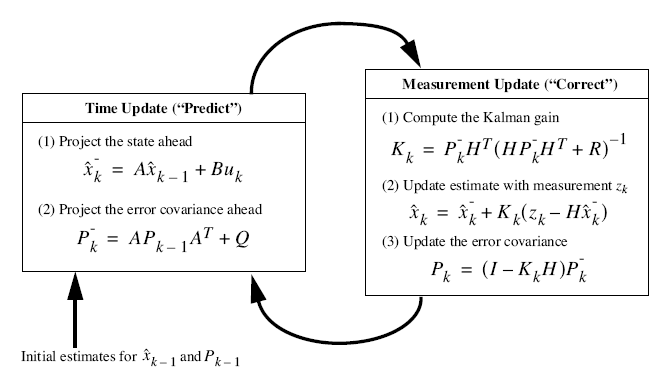

The kinematic equations of a differential-drive robot are given, allowing us to define the A and B matrices.

<div>
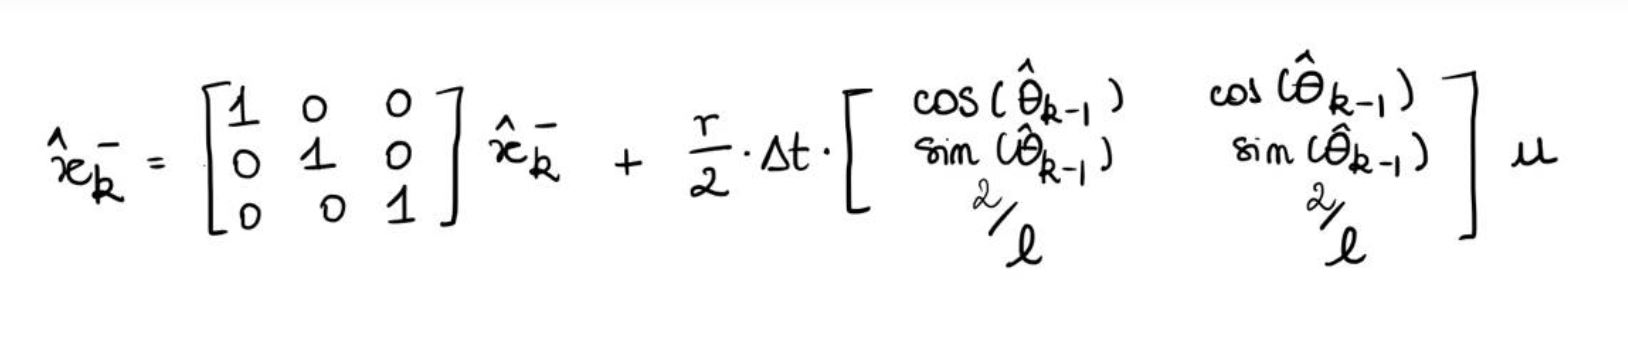
</div>

## Implementation <a name="kalimplementation"></a>

The variables used are:
- __State_est_t, P_est_t__ : State_est_t it is the previous state during the prediction state, its composants are [x position, y position, angle], and P_est_t is the covariance matrix that we initialize as a diagonal matrix with 1000 as its diagonal composant, but it will be updated later
- __State_t, P_t__: the state and covariance matrix after the update step
- __A__: the identity matrix in our case
- __B__: it has been computed following the kinematic equations of a differential-drive robot
- __u__: the input vector, containing the speeds of the two wheels
- __H__: the observation matrix (here it is the identity matrix because we observe our 3 states during the update step)
- __K__: the Kalman gain
- __Q_t and R_t__: noise covariances matrices. For simplicity reasons, they have been chosen thanks to the 8th exercise session of the course.
- __Z_t__: the measurements coming from the camera sensor
- __temps_ecoule__: the time it takes to compute one while loop, it has been calculated beforehand and found that it takes 0.01s
- __r__: the radius of the Thymio wheels
- __l__: the length between the Thymio wheels

During the update step there are two cases that can happen, and depend on __MaskAvailable__: 

- when MaskAvailable is True, it means the camera sensor is available and we receive the Z_t measurements, so the updates are computed. 
- if MaskAvailable is not available, then we are stuck in the prediction step and the Kalman gain is set to 0 to allow that.

In the program it is calculated as follows:

__Note__: The angle has to be converted to degrees at the end of the prediction. 

In [26]:
def prediction(State_est_t_1,P_t_1,Q_t,left_speed,right_speed, temps_ecoule):
    k_v = 1
    k_d= 1
    r=2*k_d
    l=9.5*k_d
    State_est_t=State_est_t_1
    State_est_t_1[2]=np.deg2rad(State_est_t_1[2])
    
    
    A = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    
    B= np.array([[(r/2)*temps_ecoule*np.cos(State_est_t_1[2]),(r/2)*temps_ecoule*np.cos(State_est_t_1[2])], 
                 [(r/2)*temps_ecoule*np.sin(State_est_t_1[2]),(r/2)*temps_ecoule*np.sin(State_est_t_1[2])], 
                 [r*temps_ecoule/l, r*temps_ecoule/(-l)]])
    
    u=[left_speed*k_v, right_speed*k_v]
    
    State_est_t=np.dot(A,State_est_t_1)+np.dot(B,u)    
    P_t_1 = np.dot(np.dot(A,P_t_1),A.T) + Q_t
    
    State_est_t[2]=np.rad2deg(State_est_t[2])

    return State_est_t,P_t_1

When this is done, what follows is the update of the parameters, with the two cases for __MaskAvailable__.

In [27]:
def update(State_est_t,P_t,Z_t,R_t, MaskAvailable, points, angle):
    H=np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]) #matrice d'observation
    
    S = np.dot(np.dot(H,P_t),H.T) + R_t
    
    if MaskAvailable:
        K = np.dot(np.dot(P_t,H.T),np.linalg.inv(S))
    else:
        K=0
    
    y = Z_t - np.dot(H,State_est_t)
   
    State_t = State_est_t + np.dot(K,y)
    
    I = np.eye(3)
    P_t = np.dot((I - np.dot(K,H)),P_t)
        
    return State_t,P_t

## Discussion <a name="kaldiscussion"></a>

The Kalman filter works just as hoped when both sensors are used: there is a small error during the predicting step, that is quickly corrected by the innovation/residual during the update step.

However, when the camera is hidden, if an error starts appearing, it will not be corrected and it could delay the robot. That is why working with sensor-fusion with both sensors is the best way to know the robot's position. Since the setup and recognition of the robot relies heavily on the lightning of the room, the way the camera is hidden also heavily affects the filter: when the object is removed, lots of red and green points appear and lead to a wrong localization of the robot.

## 5. Overall Code Implementation<a name="ov"></a>

Now that we have the map, the goal, obstacles, start, we can start to navigate the Thymio. First, we initialize the variables for the functions stated above so as to not get errors.

First the controller variables:

In [33]:
Ul= 0 
Ur= 0
Es= 0 
Et=0
phi=0
marge_s = 40
marge_t = 5
current = 0
Xt = new_checkpoint_y
Yt = new_checkpoint_x

For the Kalman filter: 

In [34]:
State_est_t=[0, 0, 0] 
Q_t = np.diag([0.0004, 0.0615, 0.0004])
R_t=np.diag([0.0025, 0.0615, 0])
angle_deg=0
points=[[0], [0], [0]]
P_t = np.diag([1000.0, 1000.0, 1000.0])
temps_ecoule=0.01
Z_t=[0,0,0]
j=0
State_t=[0,0,0]
P_t=np.diag([1000,1000,1000])
prev_state = [[0,0,0] for i in range(0, 50)]

For the local navigation:

In [35]:
speedGain = 2      # gain used with ground gradient
obstThrH = 20      # high obstacle threshold to switch state 0->1
obstSpeedGain = 10  # /100 (actual gain: 5/100=0.05)
state = 0        # 0=follow the trajectory, 1=obstacle avoidance
obst = [0,0]       # measurements from left and right prox sensors
tourne_g = 0
prox_horizontal = [0,0,0,0,0,0,0]

Now we will start working in an infinite while loop that can be stopped if the user presses on the __'q'__ button while on the Python tab. 

The new variables introduced in this program are: 
- __prev_state__: it is an array that will store all the position values and will be very efficient for the Kalman filter. We had noticed that when the camera was hidden, the coordinates that were sent didn't change during the whole time it was hidden, so we use this array to see if the Thymio positions are the same for a certain time, then we are in the __MaskAvailable=False__ condition.

The steps followed by the algorithm are:
1. Track the Thymio in real time: find its (x,y) coordinates, and its angle
2. When a checkpoint is passed, we skip it to avoid the Thymio going back
3. We send the positions to the Kalman filter as the __Z_t__ measurements to help with the update step.
4. The updated estimations are sent to the controller: these estimations will be correct when the camera is available, if it is not, the controller will use the prediction estimations to keep navigating.
5. The proximity values are taken every 0.01s, so as to not miss if an obstacle is put on the way.
6. If an obstacle is detected, go into obstacle avoidance mode. Once it is not detected anymore, it goes back to global navigation.
7. Once it has reached the goal, the thymio stops.

In [36]:
capt = cv2.VideoCapture(0) 
while True:
    _, frame = capt.read()
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Dislay the goal 
    cv2.circle(frame,(goal_pix[0],goal_pix[1]),7,(255,255,255),-1)
    
    # Display the checkpoints:
    for i in range(len(new_checkpoint_x)):
        cv2.circle(frame,(new_checkpoint_y[i],new_checkpoint_x[i]),5,(0,255,255),-1)
        
    
#1. Position in real time of the Thymio
    # Track red dot
    lower_mask = cv2.inRange(hsv_frame, lower1, upper1)
    upper_mask = cv2.inRange(hsv_frame, lower2, upper2)
    red_mask = lower_mask + upper_mask;
    red = cv2.bitwise_and(result, result, mask=red_mask)
    contours, hierarchy = cv2.findContours(red_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        area = cv2.contourArea(c)
        if area > 300:
            cv2.drawContours(frame,[c],-1,(0,0,255), 3)
            M = cv2.moments(c)
            cx_red_rt = int(M["m10"]/ M["m00"])
            cy_red_rt = int(M["m01"]/ M["m00"])
            cv2.circle(frame,(cx_red_rt,cy_red_rt),7,(0,0,255),-1)
            pt_thymio_red_rt =  [cx_red_rt, cy_red_rt]
    
    # Track green dot:
    green_mask = cv2.inRange(hsv_frame, low_green, high_green)
    green = cv2.bitwise_and(frame, frame, mask=green_mask)
    contours, hierarchy = cv2.findContours(green_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        area = cv2.contourArea(c)
        if area > 300:
            cv2.drawContours(frame,[c],-1,(0,0,255), 3)
            M = cv2.moments(c)
            cx_green_rt = int(M["m10"]/ M["m00"])
            cy_green_rt = int(M["m01"]/ M["m00"])
            cv2.circle(frame,(cx_green_rt,cy_green_rt),7,(0,255,0),-1)
            pt_thymio_green_rt =  [cx_green_rt, cy_green_rt]
    
    # Position of the Thymio
    position_thymio_rt = [round((pt_thymio_green_rt[0] + pt_thymio_red_rt[0])/2), round((pt_thymio_green_rt[1] + pt_thymio_red_rt[1])/2)]                  
    
    cv2.circle(frame,(position_thymio_rt[0],position_thymio_rt[1]),7,(255,255,255),-1)
    cv2.putText(frame, str(position_thymio_rt[0]), (position_thymio_rt[0]-150,position_thymio_rt[1]), 2,2, (255,255,255))
    cv2.putText(frame, str(position_thymio_rt[1]), (position_thymio_rt[0]+40,position_thymio_rt[1]), 2,2, (255,255,255))
    

#2. Angle in real time:
    direct_thymio = [pt_thymio_green_rt[0]-pt_thymio_red_rt[0], pt_thymio_green_rt[1]-pt_thymio_red_rt[1]]            
    vector_ref = [1, 0]            
    unit_direct_thymio = direct_thymio / np.linalg.norm(direct_thymio)                
    dot_product = np.dot(unit_direct_thymio, vector_ref)
    angle = np.arccos(dot_product)
    angle_deg = 360*angle/(2*np.pi) 
   
    if unit_direct_thymio[1] <= 0: 
        angle_deg = -angle_deg 
                    
    if unit_direct_thymio[1] > 0:
        angle_deg = angle_deg 
               
    cv2.putText(frame, str(angle_deg), (0,50), 2,2, (255,255,255))

#3. Kalman: 

    j=j+1
    if j==50:
        j=0
    
    prev_state[j] = Z_t    
    points=[position_thymio_rt[0],position_thymio_rt[1],angle_deg]
                    
    if prev_state[j]==prev_state[j-5]:
        MaskAvailable=False
        print('IMAGE FROM CAMERA NOT AVAILABLE')
    else:
        MaskAvailable=True
        
    Z_t=[position_thymio_rt[0],position_thymio_rt[1],angle_deg]
                
    left_speed=Ul
    right_speed=Ur
                
    State_est_t,P_est_t=prediction(State_t,P_t,Q_t,left_speed,right_speed,temps_ecoule)    
    State_t,P_t=update(State_est_t,P_est_t,Z_t,R_t,MaskAvailable, points, angle)

    cv2.circle(frame,(int(State_t[0]), int(State_t[1])), 7, (255, 0, 0), 5)
    

# 4. Local navigation

    await node.wait_for_variables({"prox.horizontal"})

    for i in range(0, 6):
        prox_horizontal[i]=list(node.v.prox.horizontal)[i]
    await client.sleep(0.01)
                
    obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
    
    #4.1 If no obstacles are detected, the Thymio follows the trajectory 
    if state == 0: 
        
        # Switch from goal tracking to obstacle avoidance if obstacle detected
        if (prox_horizontal[0] > obstThrH or  prox_horizontal[1] > obstThrH or prox_horizontal[2] > obstThrH or prox_horizontal[3] > obstThrH or prox_horizontal[4] > obstThrH ):
            state = 1
       
        Xr = State_t[0]
        Yr = State_t[1]
        theta_r = State_t[2]

        # To prevent the Thymio to move back, we skip a checkpoint when he passed it 
        # (Very useful when we use the Kalman filter without the camera informations)
        if(Xr>Xt[current]+100):
            current = current+1
                        
        if current < len(Xt): 
            Ul, Ur, Es, Et, phi = controller(Xr, Yr, theta_r, Xt[current], Yt[current])
                
            if abs(Es) > marge_s or abs(Et) > marge_t:
                Ul, Ur, Es, Et, phi = controller(Xr, Yr, theta_r, Xt[current], Yt[current])
                node.send_set_variables(motors(Ul, Ur))
                cv2.putText(frame,str(phi) , (0,200), 2,2, (255,255,255))

                
            else:
                current = current + 1
                if current==len(Xt):
                    break
                          
    #4.2 If an obstacle is detected, thymio switch to local avoidance
    else: 
        print("LOCAL")
        #If the obstacle is too close from the checkpoint we can skip it
        if np.sqrt((Xr-Xt[current])**2+(Yr-Yt[current])**2)<250 :
                current = current+1
        
        # Motor commands to avoid the obstacle
        Ul= obstSpeedGain * (-obst[0] // 50) - (obst[2]//50)*obstSpeedGain - (obst[1]//50)*obstSpeedGain
        Ur= obstSpeedGain * (-obst[4] // 50) - (obst[2]//50)*obstSpeedGain - (obst[3]//50)*obstSpeedGain

        
        if obst[4] > obstThrH or obst[3] > obstThrH:
            tourne_g = 1
        
        if obst[0] > obstThrH or obst[1] > obstThrH:
            tourne_g = 0
            
        node.send_set_variables(motors(Ul, Ur))
            
        
        # obstacle avoided
        if (obst[0] < obstThrH) and (obst[1] < obstThrH) and  (obst[2] < obstThrH) and (obst[3] < obstThrH) and (obst[4] < obstThrH):
            if tourne_g == 0:
                Ul = 100
                Ur = -100
                    
            if tourne_g == 1:
                Ul = -100
                Ur = 100
                        
            node.send_set_variables(motors(Ul, Ur))
            await client.sleep(1.5)
            Ul = 100
            Ur = 100
            node.send_set_variables(motors(Ul, Ur))
            await client.sleep(8)
            #If the checkpoint was passed during the obstacle avoidance step, we skip it
            if Xr>Xt[current]:
                current = current+1
                    
            state = 0
    
    
  
    cv2.imshow("result",frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print(Xr, Yr, goal_pix[0], goal_pix[1])
        node.send_set_variables(motors(0, 0))
        break

node.send_set_variables(motors(0, 0))

IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
IMAGE FROM CAMERA NOT AVAILABLE
LOCAL
LOCAL
LOCAL
LOCAL
LOCAL
LOCAL
LOCAL
LOCAL
LOCAL


And we unlock the robot.

In [ ]:
await node.unlock()

## 8. Conclusion<a name="con"></a>

Overall, the results are pretty good: the robot indeed follows its initial calculated path, avoids obstacles that were not planned and can locate itself on the map thanks to the filter. 
With the time given, the project was made as simple as possible, so very easy to implement, but still as efficient as possible. However, it can work very well only in good lightning conditions, the user has to be very aware of the lightning of the room, and the colours of the objects used. 

## Feedback <a name="feedback"></a>

It was very challenging given the short delay; we had to keep the implementation and function very basic. Overall it was a great, stressful, experience where we learned a lot.

## 9. Appendix <a name="appendix"></a>

## Electronic devices used <a name="elec"></a>

- Thymio robot (both wireless and with cable)
- Aukey camera pc w1: this is a full HD webcam with 30 FPS. It is more than enough, in fact as later explained most of the images are resized to help the programm to run faster.

## Video of the implementation <a name="video"></a>

The video can be found in the zip folder, under the name "video.mp4".

## References<a name="ref"></a>

- Introduction to Mobile Robotics, Mondada
- How a Kalman filter works in pictures: https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/
- Opencv tutorial videos: https://www.youtube.com/playlist?list=PLzMcBGfZo4-lUA8uGjeXhBUUzPYc6vZRn
- Position and Orientation Control of a Two-Wheeled Differentially Driven Nonholonomic Mobile Robot.,Frederico C. VIEIRA    Adelardo A. D. MEDEIROS Pablo J. ALSINA Antonio ˆ P. ARAU´ JO Jr, https://www.researchgate.net/publication/221645976_Position_and_Orientation_Control_of_a_Two-Wheeled_Differentially_Driven_Nonholonomic_Mobile_Robot